# <a id="contents"></a> Table of Contents

1. [Research Question](#research-question)
2. [Import Libraries](#imports)
3. [Standardizing Data](#standardizing-data)
4. [Loading Position Data](#loading-data)
5. [Descriptive Statistics and Visualization](#descriptive-stats)
   - 5.1 [Descriptive Statistics Calculation](#descriptive-stats-calc)
   - 5.2 [Displaying Descriptive Statistics as Heatmap](#descriptive-stats-heatmap)
6. [Distribution and Box Plot Visualization](#distribution-and-box-plot)
7. [Correlation Heatmaps](#correlation-heatmaps)
8. [PCA](#baseline-models)
   - 8.1 [Defense PCA Baseline](#baseline-models-defense)
   - 8.2 [Midfielder PCA Baseline](#baseline-models-midfielder)
   - 8.3 [Goalkeeper PCA Baseline](#baseline-models-goalkeeper)
   - 8.4 [Forward PCA Baseline](#baseline-models-forward)


<a id="research-question"></a>

## <div class='section'>Section 1: Research Question</div>


How do players' skills across different positions in the top five European soccer leagues compare and cluster based on principal components derived from performance metrics, and who are the best players for each position? For our final project, we utilized data scraped from FBref.com to perform a Principal Component Analysis to explore similarities across top players and their respective positions.

<a id="imports"></a>

## <div class='section'>Section 2: Import Libraries</div>


In [31]:
import itertools
import math
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.utils import resample


# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

<a id="standardizing-data"></a>

## <div class='section'>Section 3: Standardizing Data</div>

[Return to contents](#contents)

Here, we define a `standardize` function that will be used to scale and standardize the data to ensure that each feature contributes equally to any subsequent analysis so that we can avoid biases due to differences in scale. Since our project involves the use of PCA, it is essential to standardize the data to ensure that each predictor contributes equally and without bias to the principal components.

In [32]:
def standardize(df):
    
    if 'Player' in df.columns:
        player_column = df['Player']

    if 'Comp' in df.columns:
        comp_column = df['Comp']
        
    numeric_columns = df.select_dtypes(include='number').columns
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df[numeric_columns])

    standardized_df = pd.DataFrame(standardized_data, columns=numeric_columns)
    standardized_df['Player'] = player_column.reset_index(drop=True)
    standardized_df['Comp'] = comp_column.reset_index(drop=True)
    
    return standardized_df


<a id="loading-data"></a>

## <div class='section'>Section 4: Loading Position Data</div>

[Return to contents](#contents)

Here, we load and `standardize` data from CSV files for each position, then organize them in a dictionary. To improve our analysis, we seperated our data into four datasets based on the four different player positions. This distinction is important since the relevant player statistics for different positions (e.g. outfielder vs. goalkeeper) are very different, and would therefore distort our PCA if left combined. Additionally, we rename the predictors to ease interpretability within our notebook.

In [33]:
# Make dataframes
goalkeepers = standardize(pd.read_csv("stats/GK_relevant_stats.csv"))
defenders = standardize(pd.read_csv("stats/DF_relevant_stats.csv"))
midfielders = standardize(pd.read_csv("stats/MF_relevant_stats.csv"))
forwards = standardize(pd.read_csv("stats/FW_relevant_stats.csv"))

# Dictionary of dataframes for each position
dataframes = {
    'Goalkeepers': goalkeepers, 
    'Defenders': defenders, 
    'Midfielders': midfielders, 
    'Forwards': forwards
}

# Dictionary of basic stats to use for each position
basic_stats = {
    'Goalkeepers': ['GA', 'Saves', 'Save%', 'CS', 'GA90'],
    'Defenders': ['Gls', 'Ast', 'CrdY', 'CrdR', 'Tkl', 'TklW', 'Int', 'Clr'],
    'Midfielders': ['Gls', 'Ast', 'Sh', 'SoT', 'CrdY', 'Tkl', 'TklW', 'Cmp', 'Att', 'Cmp%'],
    'Forwards': ['Gls', 'Ast', 'Sh', 'SoT', 'SoT%', 'CrdY', 'Cmp', 'Att', 'Cmp%']
}

column_mapping = {
    'MP': 'Matches Played',
    'Starts': 'Starts',
    'Min': 'Minutes Played',
    '90s': '90-Minute Increments',
    'Gls': 'Goals',
    'Ast': 'Assists',
    'G+A': 'Goals + Assists',
    'G-PK': 'Goals (Excl. Penalties)',
    'PK': 'Penalty Goals',
    'PKatt': 'Penalty Attempts',
    'CrdY': 'Yellow Cards',
    'CrdR': 'Red Cards',
    'xG': 'Expected Goals',
    'npxG': 'Non-Penalty Expected Goals',
    'xAG': 'Expected Assists',
    'npxG+xAG': 'Expected Non-Penalty Goals + Assists',
    'PrgC': 'Progressive Carries',
    'PrgP': 'Progressive Passes',
    'PrgR': 'Progressive Runs',
    'Glsp90': 'Goals per 90',
    'Astp90': 'Assists per 90',
    'G+Ap90': 'Goals + Assists per 90',
    'xGp90': 'Expected Goals per 90',
    'xAGp90': 'Expected Assists per 90',
    'xG+xAGp90': 'Expected Goals + Assists per 90',
    'npxGp90': 'Non-Penalty Goals per 90',
    'npxG+xAGp90': 'Non-Penalty Goals + Assists per 90',
    'Sh': 'Shots',
    'SoT': 'Shots on Target',
    'SoT%': 'Shots on Target %',
    'Sh/90': 'Shots per 90',
    'SoT/90': 'Shots on Target per 90',
    'ShDist': 'Average Shot Distance',
    'npxG/Sh': 'Non-Penalty xG per Shot',
    'G-xG': 'Goals Minus xG',
    'Cmp': 'Passes Completed',
    'Att': 'Passes Attempted',
    'Cmp%': 'Pass Completion %',
    'PTotDist': 'Total Passing Distance',
    'PPrgDist': 'Progressive Passing Distance',
    'A-xAG': 'Assists Minus xAG',
    'KP': 'Key Passes',
    '1/3': 'Passes into Final Third',
    'PPA': 'Passes into Penalty Area',
    'Tkl': 'Tackles',
    'TklW': 'Tackles Won',
    'DTkl': 'Dribbles Tackled',
    'DTklAtt': 'Dribbles Tackled Attempts',
    'Tkl%': 'Tackle Success %',
    'Blocks': 'Blocks',
    'Int': 'Interceptions',
    'Clr': 'Clearances',
    'Touches': 'Touches',
    'Def Pen': 'Touches in Defensive Penalty Area',
    'Def 3rd': 'Touches in Defensive Third',
    'Mid 3rd': 'Touches in Midfield Third',
    'Att 3rd': 'Touches in Attacking Third',
    'Att Pen': 'Touches in Attacking Penalty Area',
    'TOAtt': 'Take-On Attempts',
    'TOSucc': 'Take-On Successes',
    'TOSucc%': 'Take-On Success %',
    'Tkld': 'Tackled',
    'Tkld%': 'Tackled %',
    'Carries': 'Carries',
    'CTotDist': 'Total Carry Distance',
    'CPrgDist': 'Progressive Carry Distance',
    'C1/3': 'Carries into Final Third',
    'CPA': 'Carries into Penalty Area',
    'Rec': 'Passes Received',
    'GA': 'Goals Allowed',
    'GA90': 'Goals Allowed per 90 Minutes',
    'SoTA': 'Shots on Target Against',
    'Saves': 'Saves Made',
    'Save%': 'Save Percentage',
    'CS': 'Clean Sheets',
    'CS%': 'Clean Sheet Percentage',
    'PSxG': 'Post-Shot Expected Goals',
    'PSxG/SoT': 'Post-Shot Expected Goals per Shot on Target',
    'PSxG+/-': 'Post-Shot Expected Goals Difference',
    'Opp': 'Opponent Shots',
    'Stp': 'Crosses Stopped',
    'Stp%': 'Crosses Stopped Percentage'
}

defenders.rename(columns=column_mapping, inplace=True)
goalkeepers.rename(columns=column_mapping, inplace=True)
midfielders.rename(columns=column_mapping, inplace=True)
forwards.rename(columns=column_mapping, inplace=True)

# Numerate leagues for regression
league_map = {
    'Premier League' : 0,
    'La Liga' : 1,
    'Bundesliga' : 2,
    'Serie A' : 3,
    'Ligue 1' : 4
}

defenders['Comp'] = defenders['Comp'].map(league_map)
goalkeepers['Comp'] = goalkeepers['Comp'].map(league_map)
midfielders['Comp'] = midfielders['Comp'].map(league_map)
forwards['Comp'] = forwards['Comp'].map(league_map)

<a id="descriptive-stats"></a>

## <div class='section'>Section 5: Descriptive Statistics and Visualization</div>

[Return to contents](#contents)

Here, we calculate and visualize descriptive statistics for each position dataset which will provide insights into the central tendency, spread, and range of values for each feature in the dataset.


<a id="descriptive-stats-calc"></a>

#### <div class='sub-section'>5.1: Descriptive Statistics Calculation</div>

Here, we calculate the mean, standard deviation, median, min, max, and range of each numeric feature in the dataset.




In [34]:
def descriptive_stats(df):
    numeric_df = df.select_dtypes(include='number')
    stats = numeric_df.describe().T  # Transpose for readability
    stats['median'] = numeric_df.median()  # Add median
    stats['range'] = stats['max'] - stats['min']  # Calculate range
    return stats[['mean', 'std', 'median', 'min', 'max', 'range']]


<a id="descriptive-stats-heatmap"></a>

#### <div class='sub-section'>5.2: Displaying Descriptive Statistics as Heatmap</div>

Here, we create heatmaps to visualize the descriptive statistics for each feature and to help us easily spot outliers, patterns, and distributions across different features.

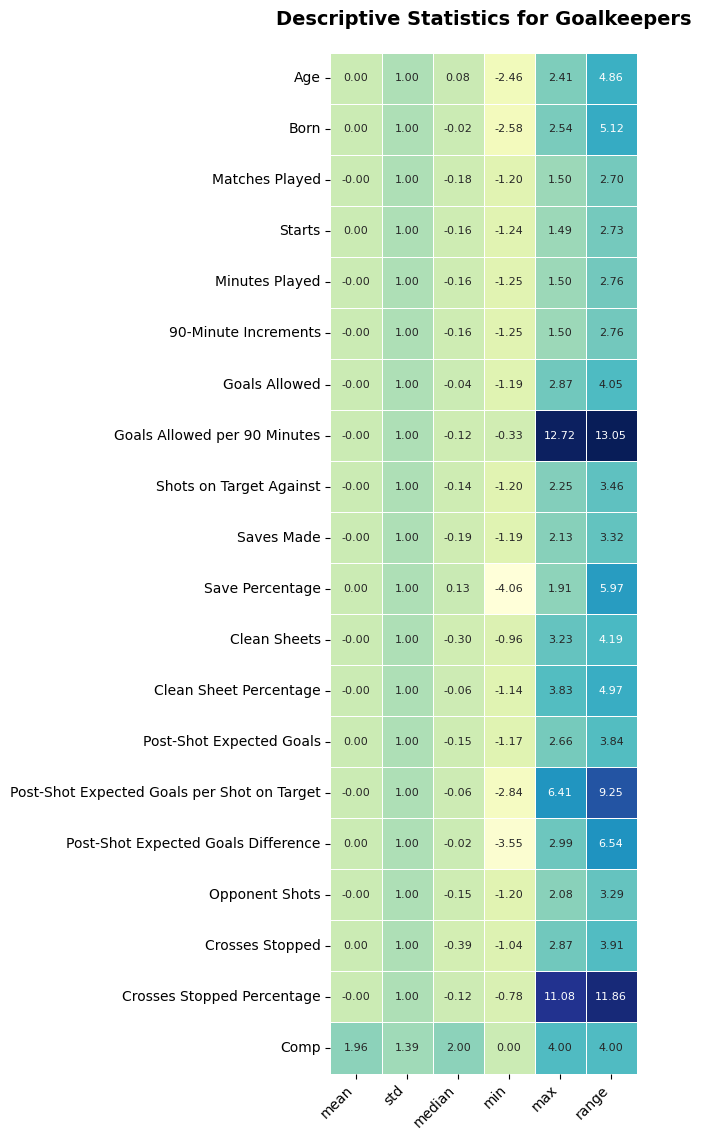

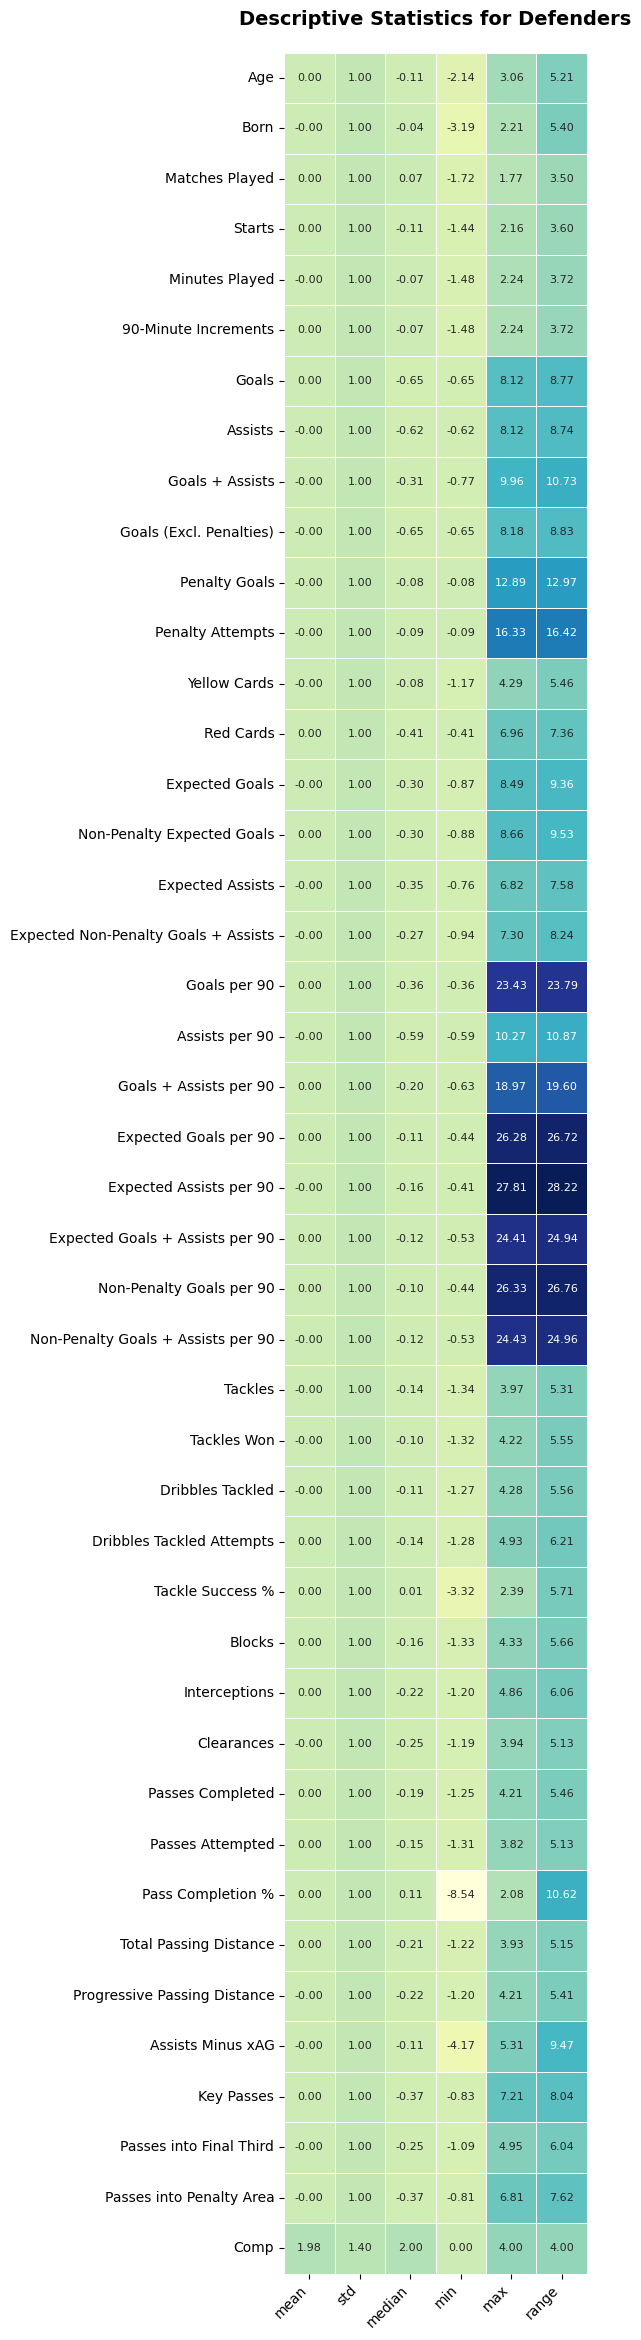

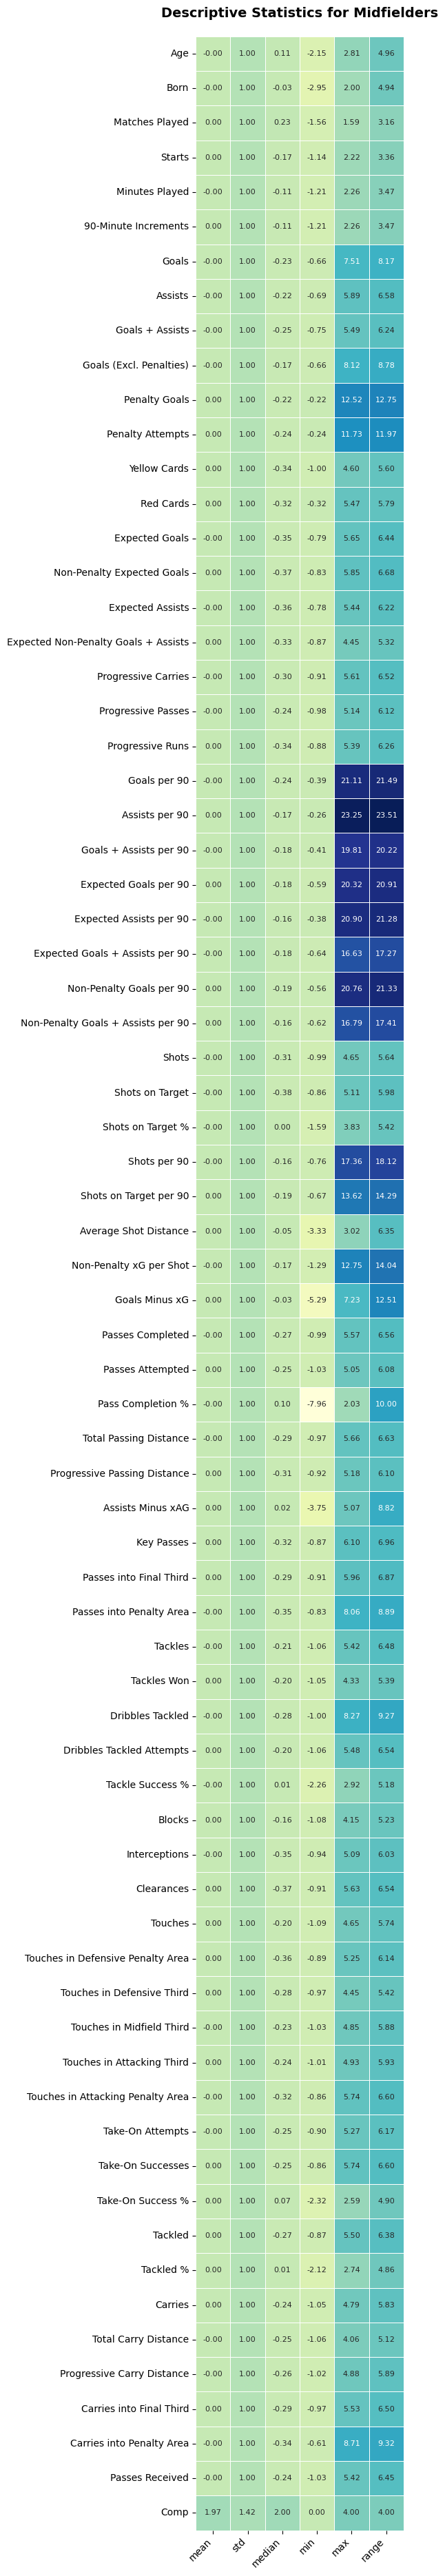

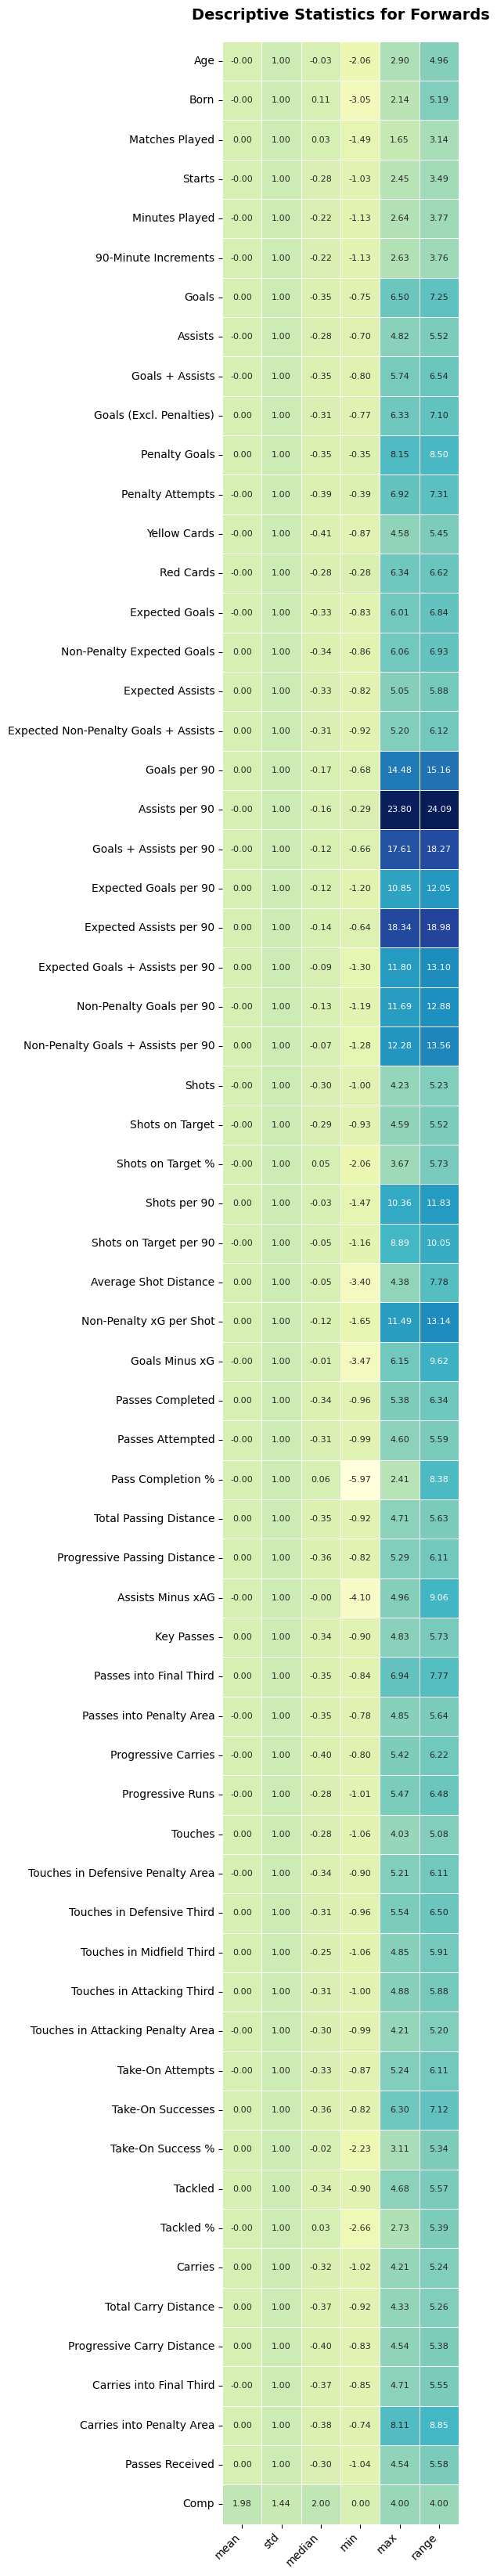

In [35]:
def display_heatmap(stats, title):
    fig, ax = plt.subplots(figsize=(12, len(stats) * 0.5 + 1.5))
    sns.heatmap(stats, annot=True, fmt=".2f", cmap="YlGnBu", cbar=False, linewidths=.5, 
                annot_kws={"size": 8}, ax=ax, square=True)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.title(title, fontweight="bold", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()


# generating and displaying heatmap tables for each position's statistics
for position, df in dataframes.items():
    stats = descriptive_stats(df)
    display_heatmap(stats, f"Descriptive Statistics for {position}")


Midfielders: 

<a id="distribution-and-box-plot-visualization"></a>

## <div class='section'>Section 6: Distribution and Box Plot Visualization</div>

[Return to contents](#contents)

Here, we generate histograms and box plots for each feature to show the distribution and identify potential outliers. The histograms provide insight into how data points are distributed while box plots reveal central tendencies and variability. The histograms and box plots are then saved as PNG files in the 'plots' folder


Saving plots for Goalkeepers...


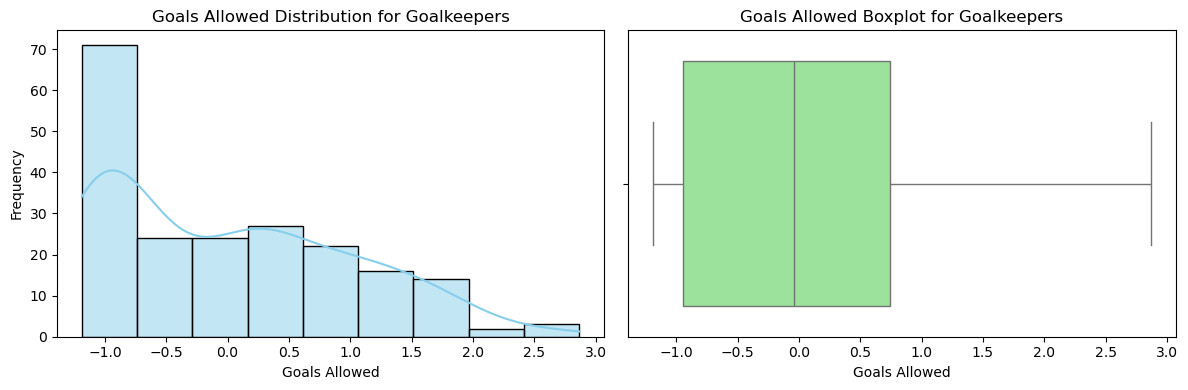

<Figure size 640x480 with 0 Axes>

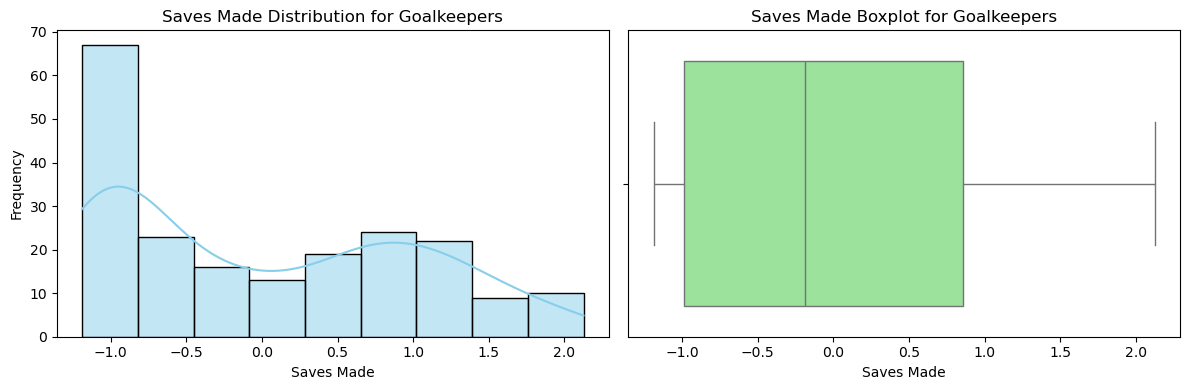

<Figure size 640x480 with 0 Axes>

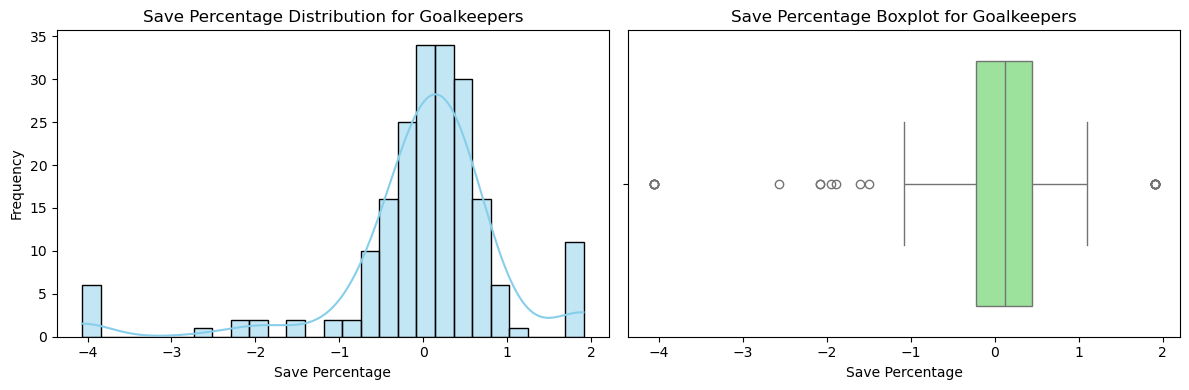

<Figure size 640x480 with 0 Axes>

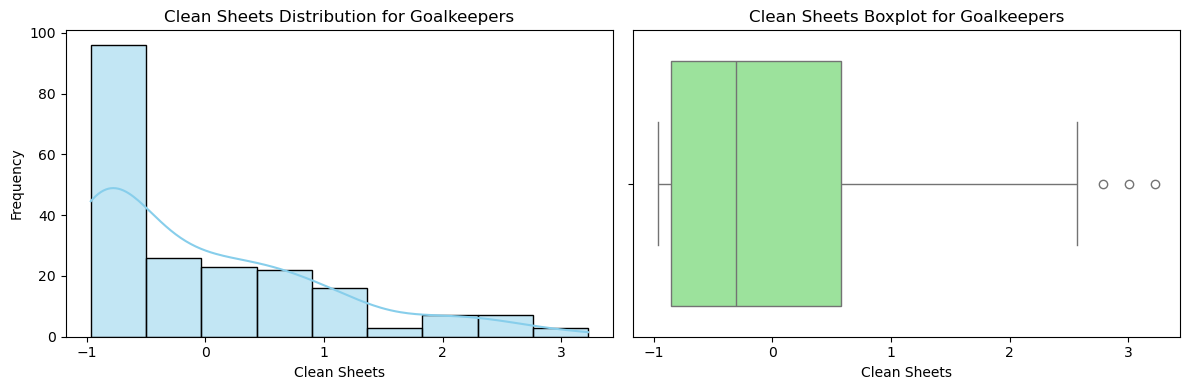

<Figure size 640x480 with 0 Axes>

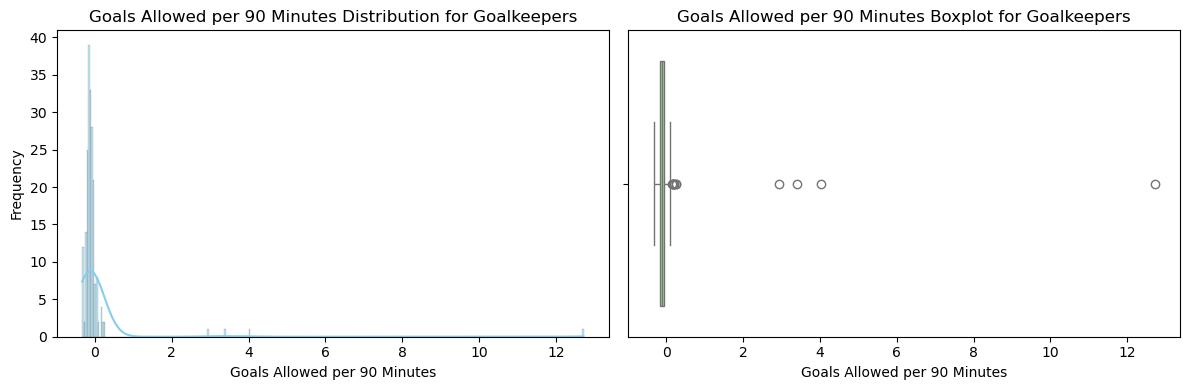

Saving plots for Defenders...


<Figure size 640x480 with 0 Axes>

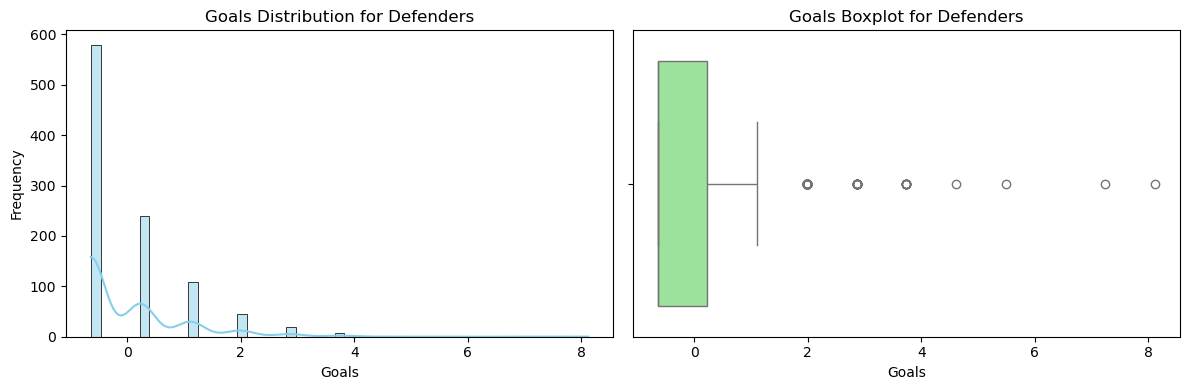

<Figure size 640x480 with 0 Axes>

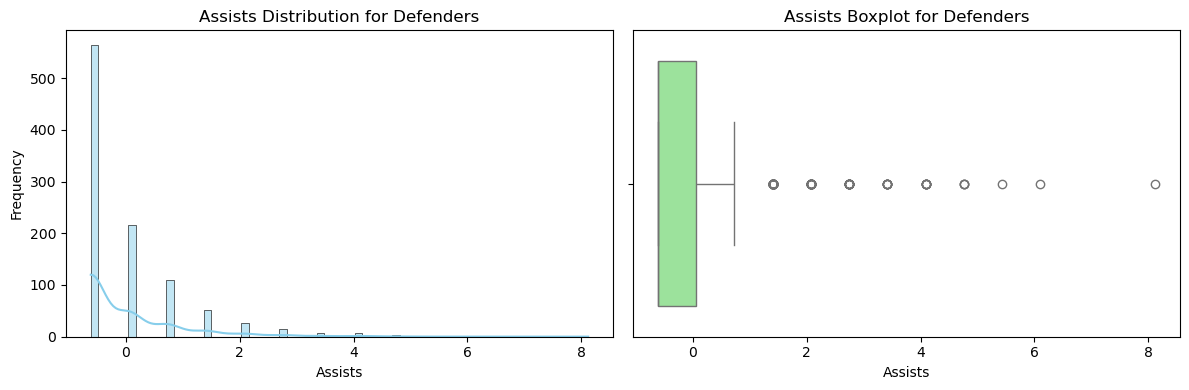

<Figure size 640x480 with 0 Axes>

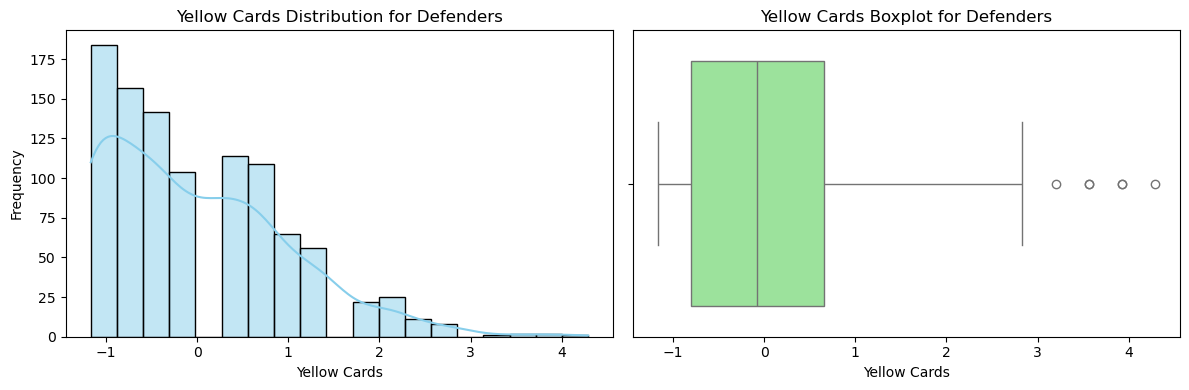

<Figure size 640x480 with 0 Axes>

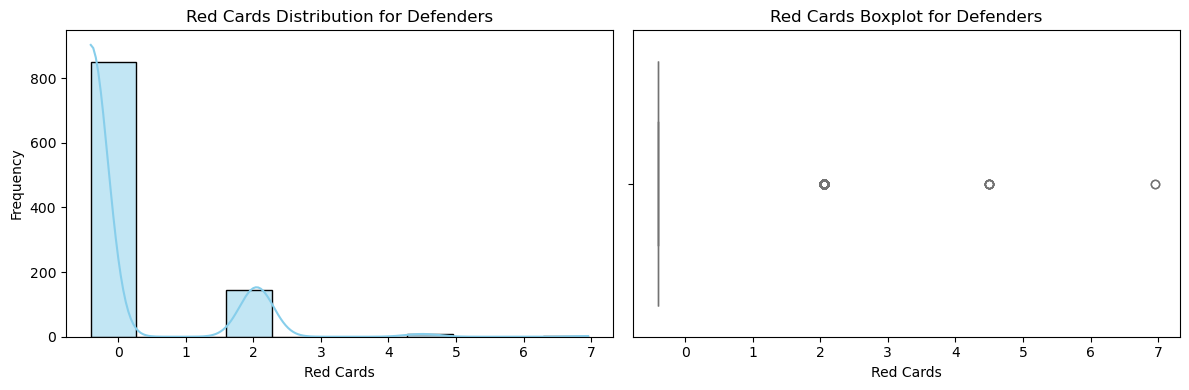

<Figure size 640x480 with 0 Axes>

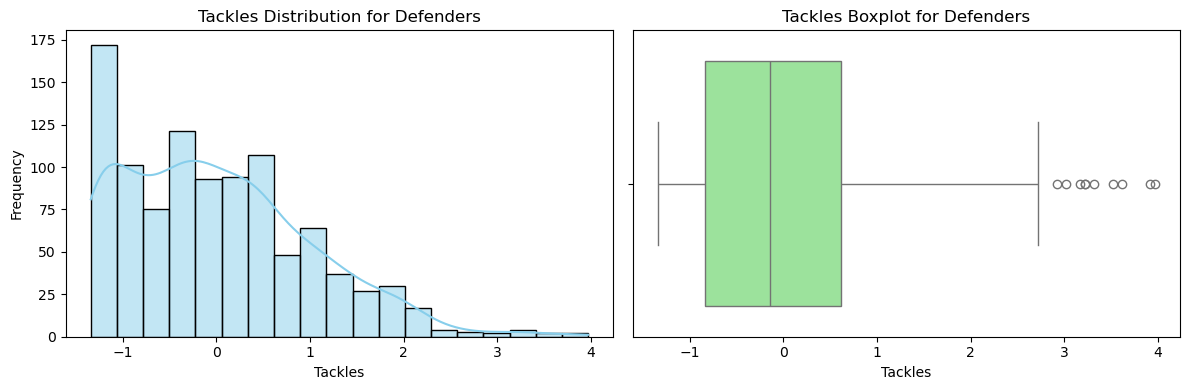

<Figure size 640x480 with 0 Axes>

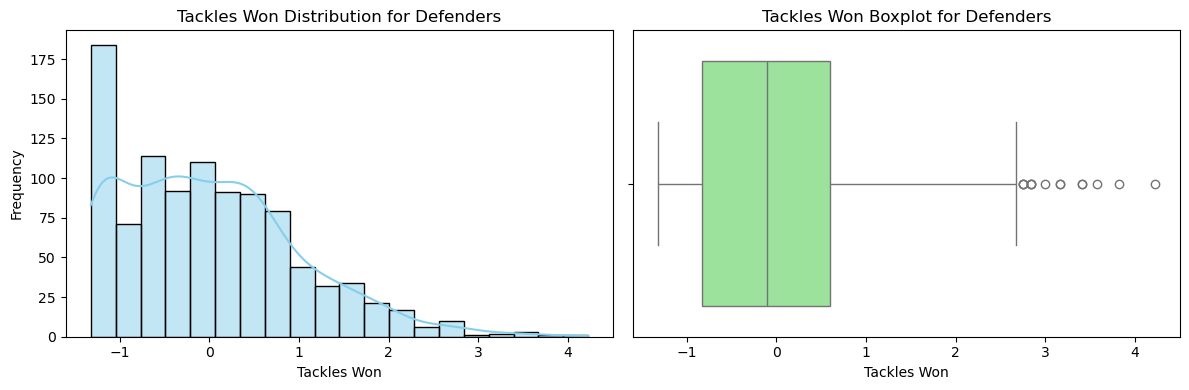

<Figure size 640x480 with 0 Axes>

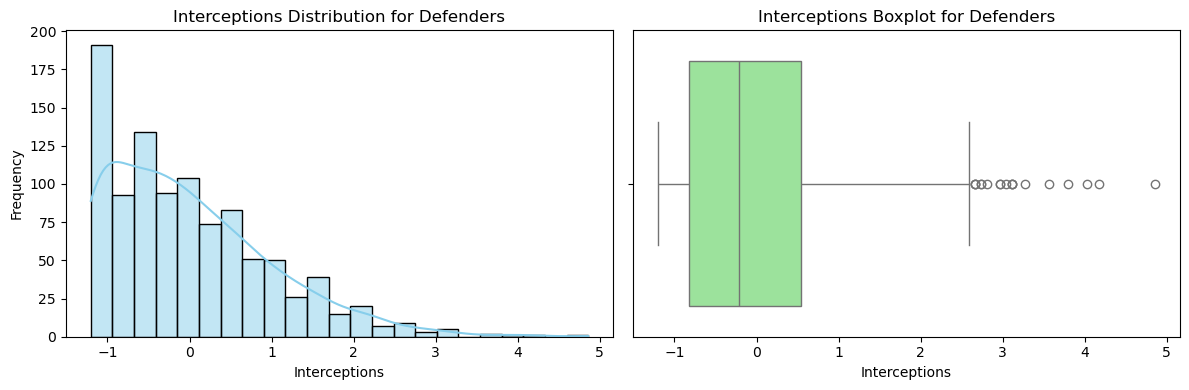

<Figure size 640x480 with 0 Axes>

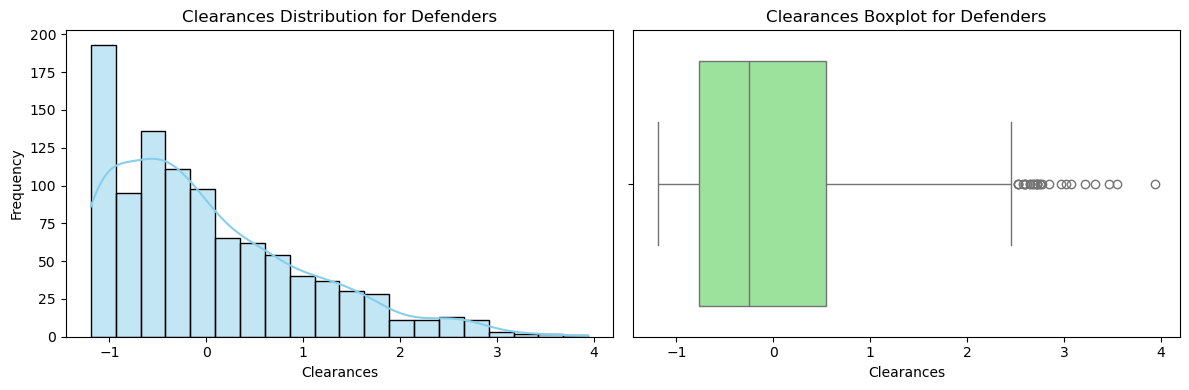

Saving plots for Midfielders...


<Figure size 640x480 with 0 Axes>

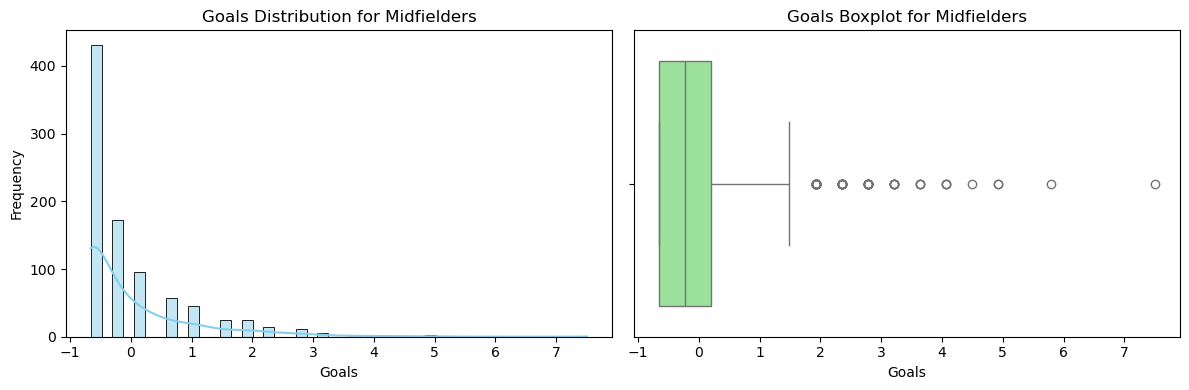

<Figure size 640x480 with 0 Axes>

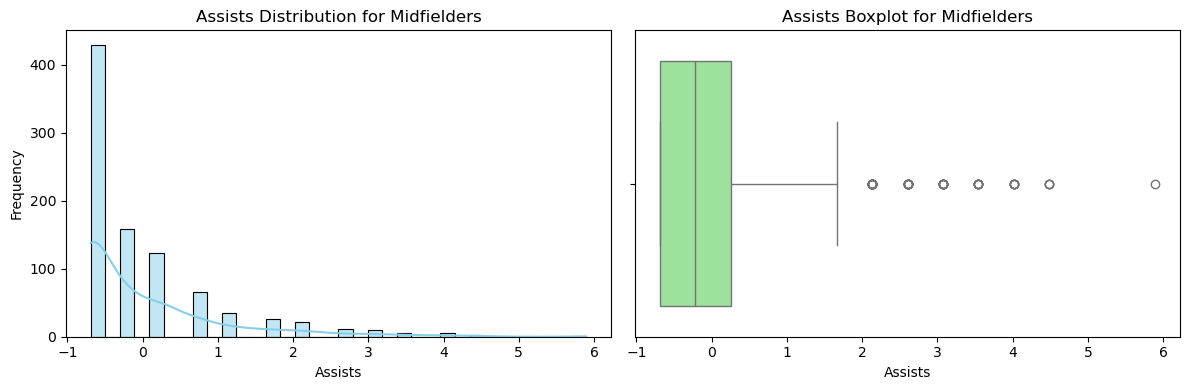

<Figure size 640x480 with 0 Axes>

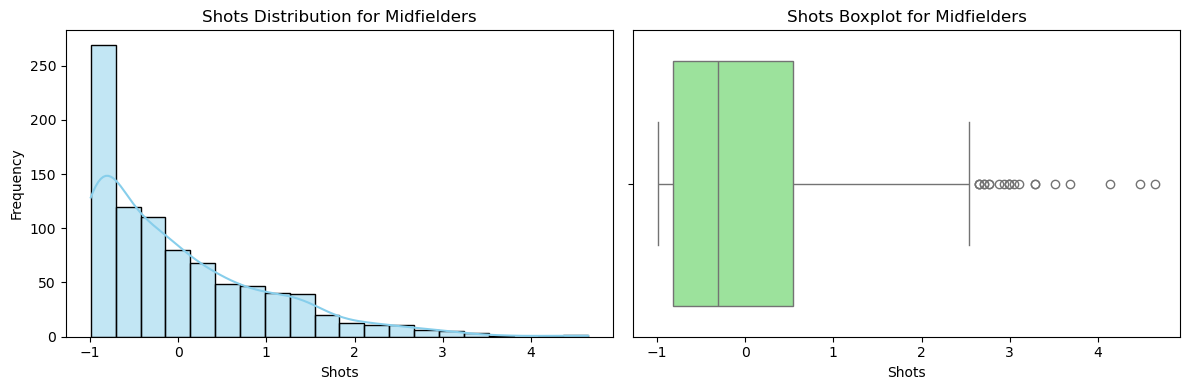

<Figure size 640x480 with 0 Axes>

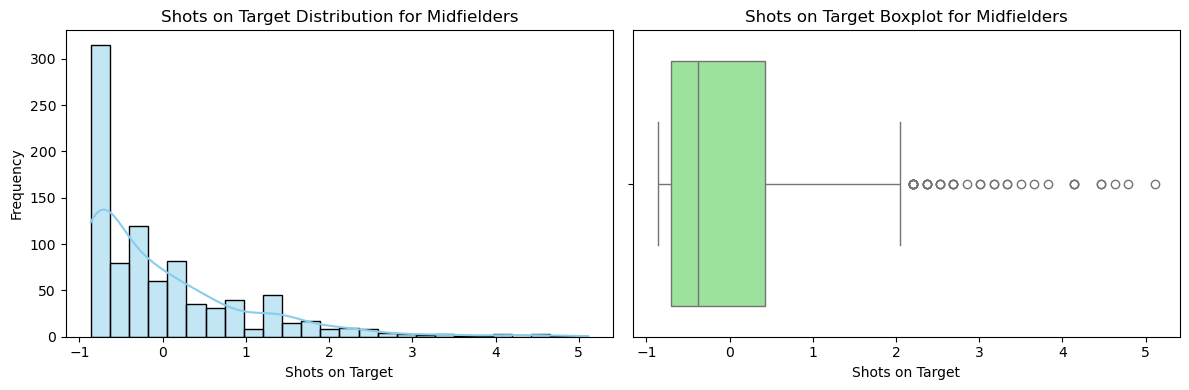

<Figure size 640x480 with 0 Axes>

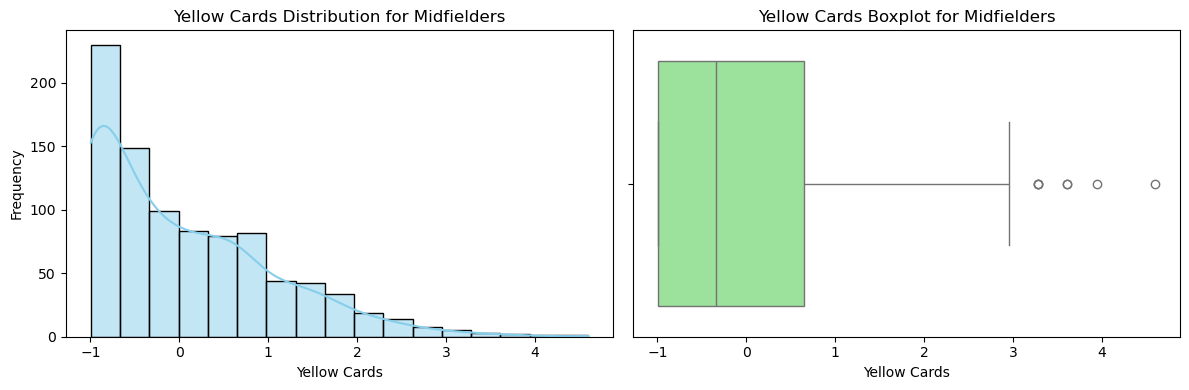

<Figure size 640x480 with 0 Axes>

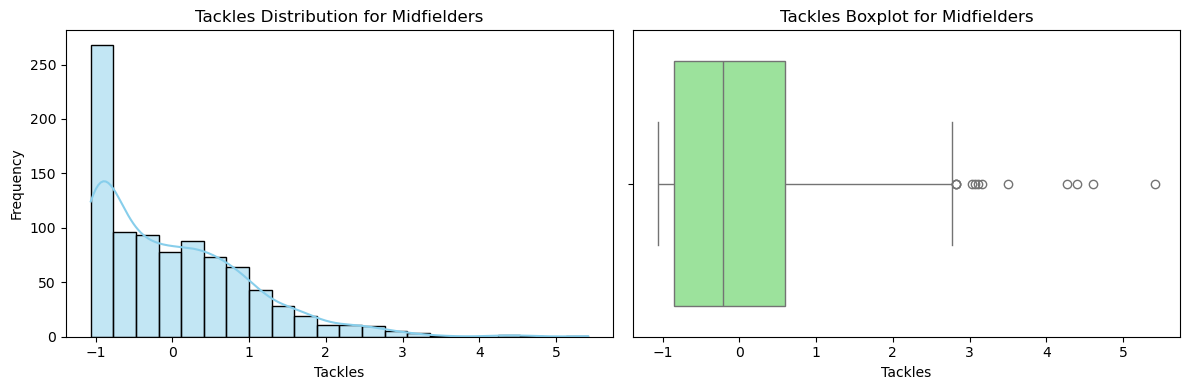

<Figure size 640x480 with 0 Axes>

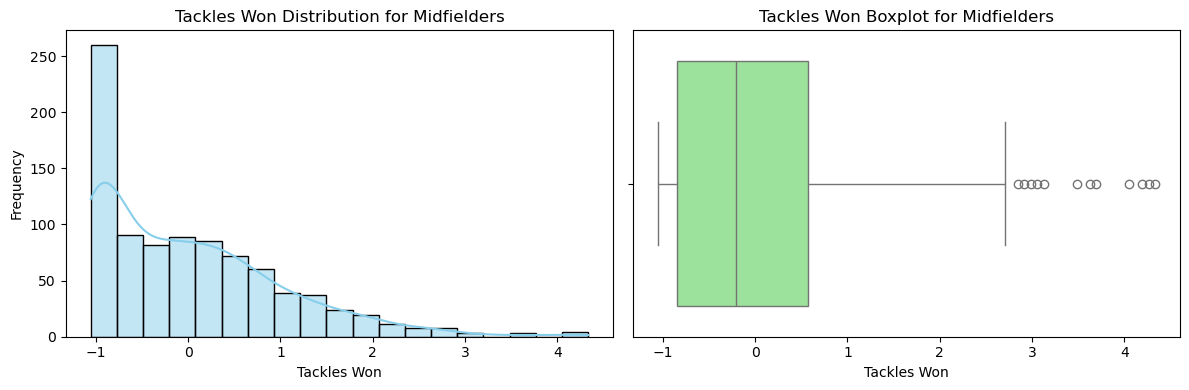

<Figure size 640x480 with 0 Axes>

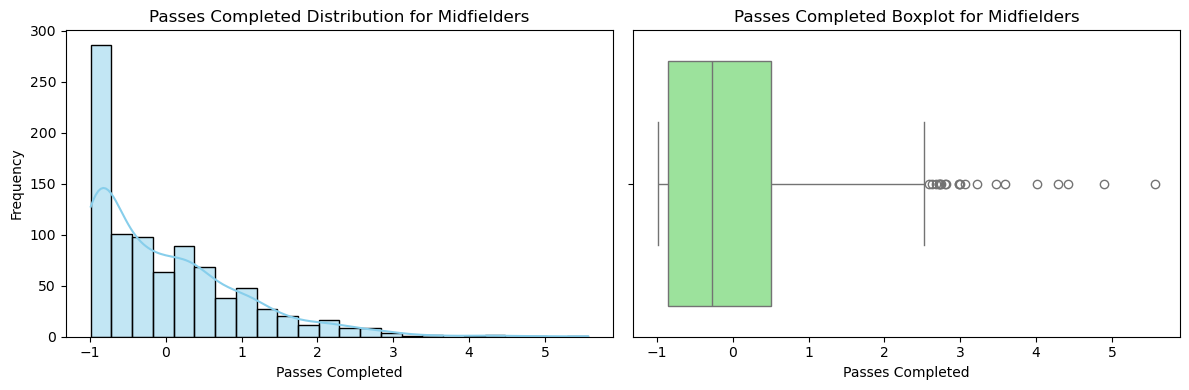

<Figure size 640x480 with 0 Axes>

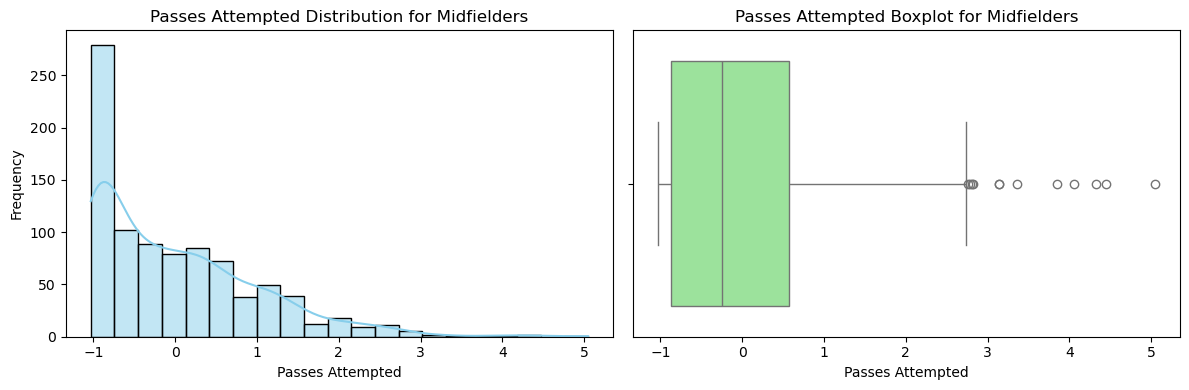

<Figure size 640x480 with 0 Axes>

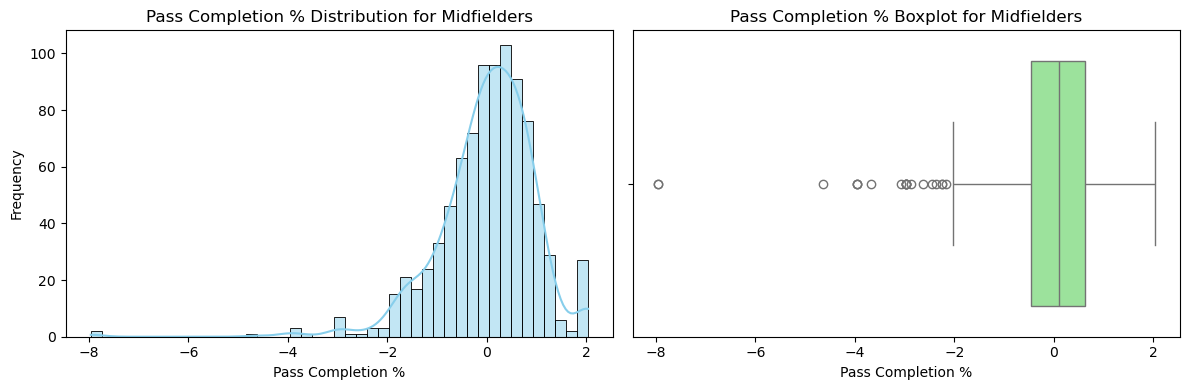

Saving plots for Forwards...


<Figure size 640x480 with 0 Axes>

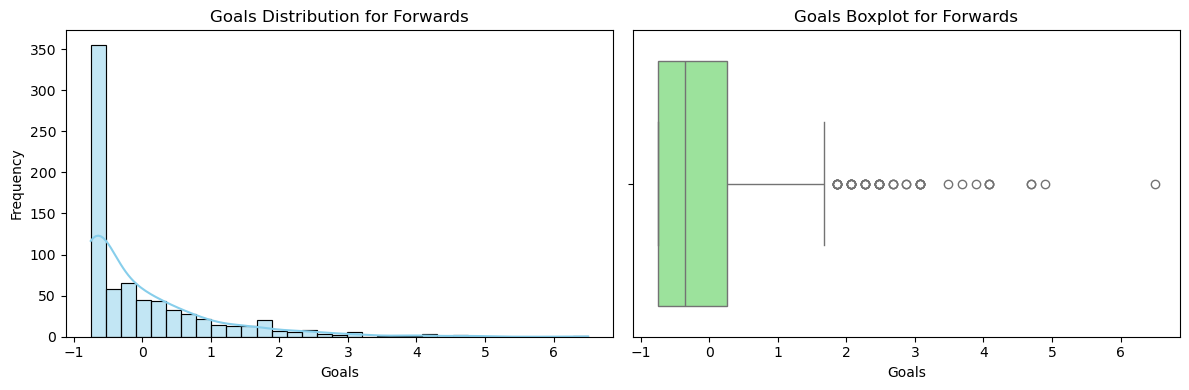

<Figure size 640x480 with 0 Axes>

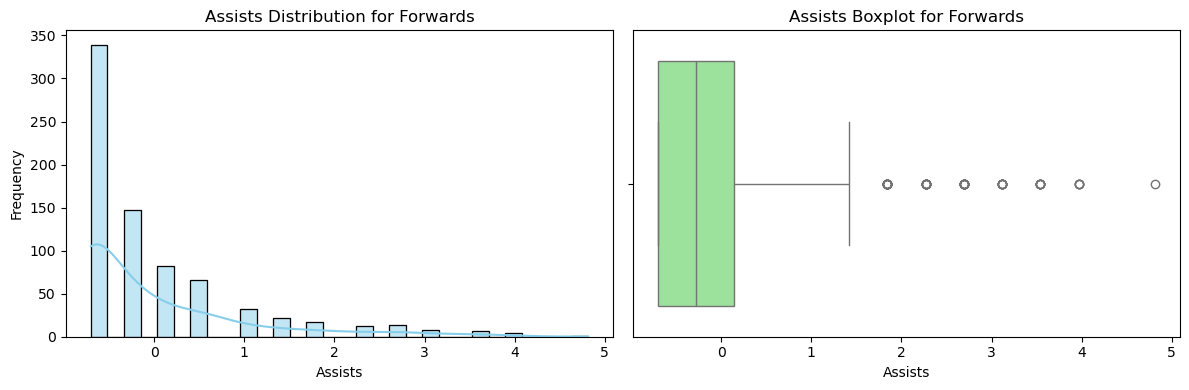

<Figure size 640x480 with 0 Axes>

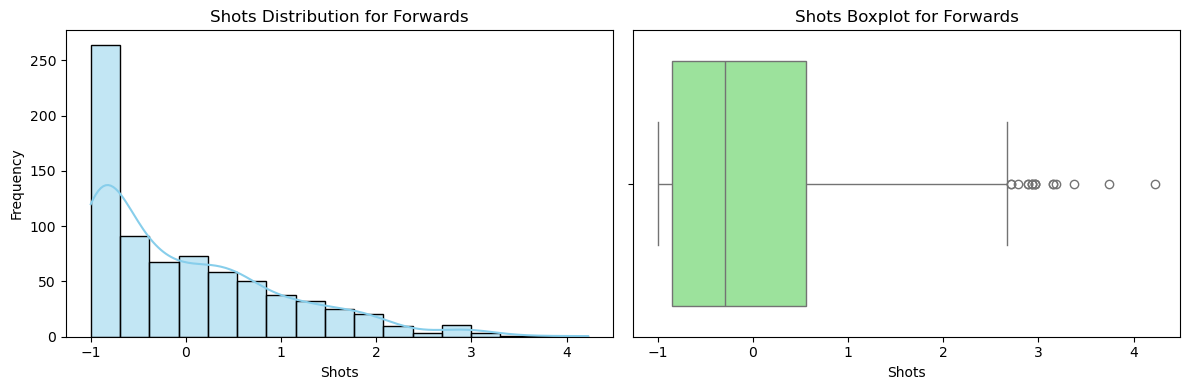

<Figure size 640x480 with 0 Axes>

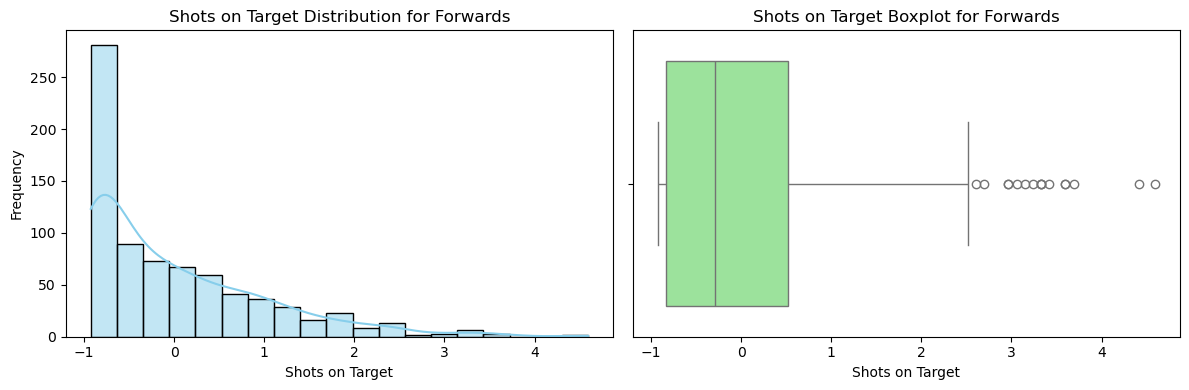

<Figure size 640x480 with 0 Axes>

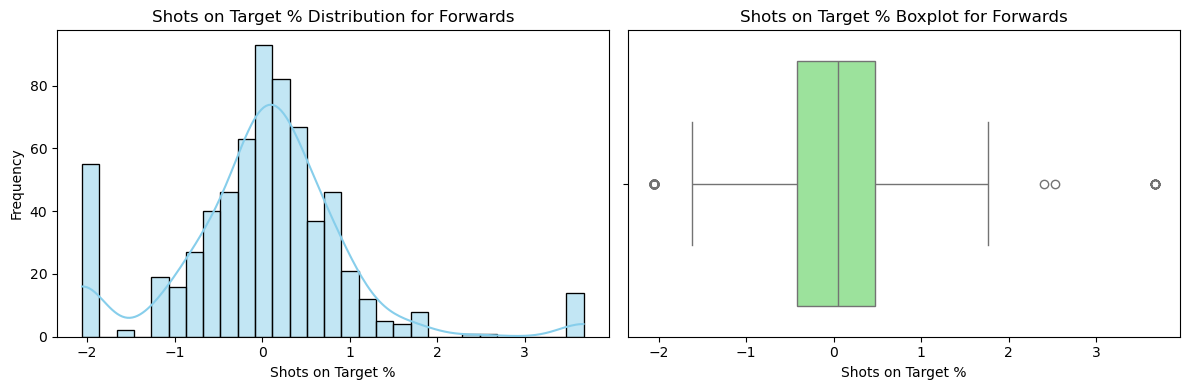

<Figure size 640x480 with 0 Axes>

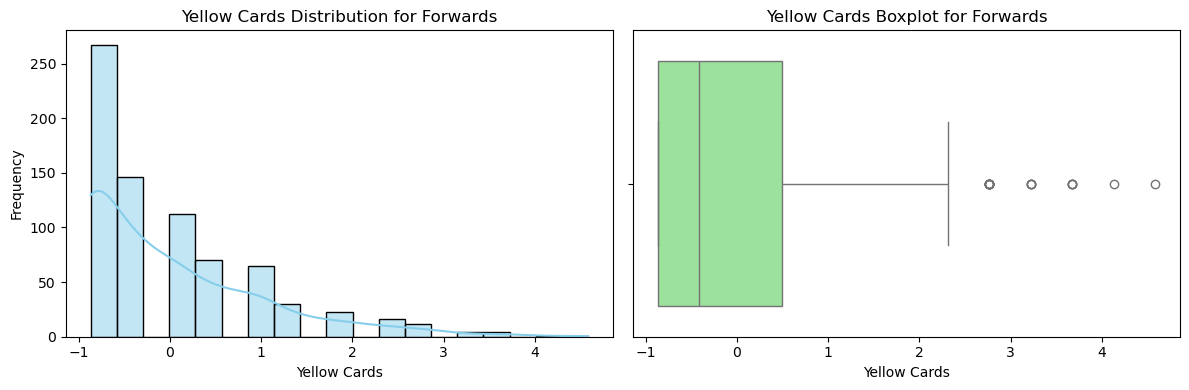

<Figure size 640x480 with 0 Axes>

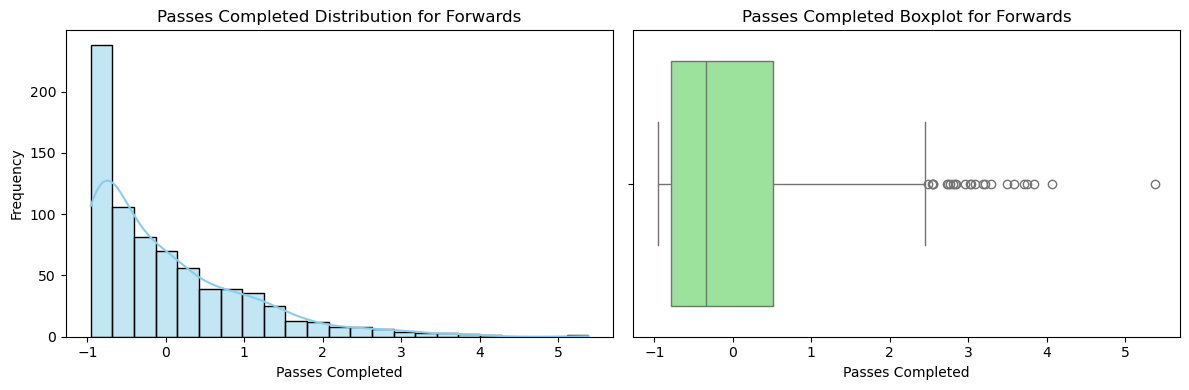

<Figure size 640x480 with 0 Axes>

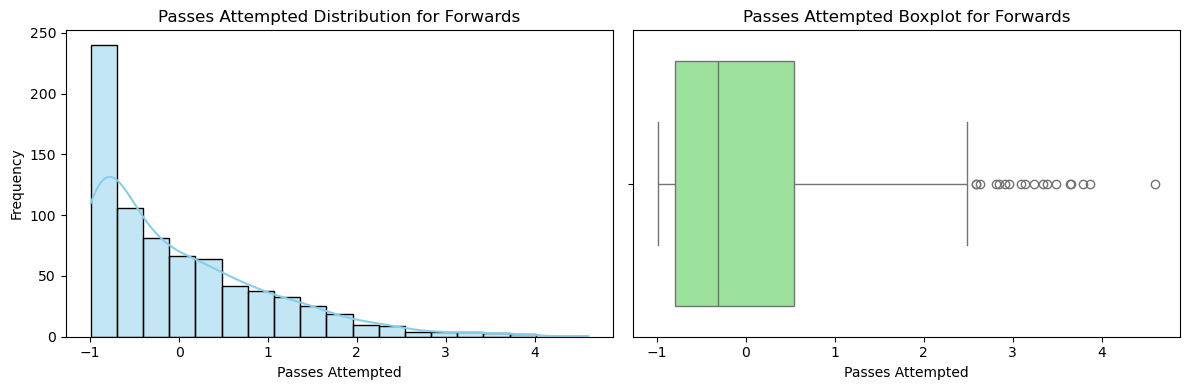

<Figure size 640x480 with 0 Axes>

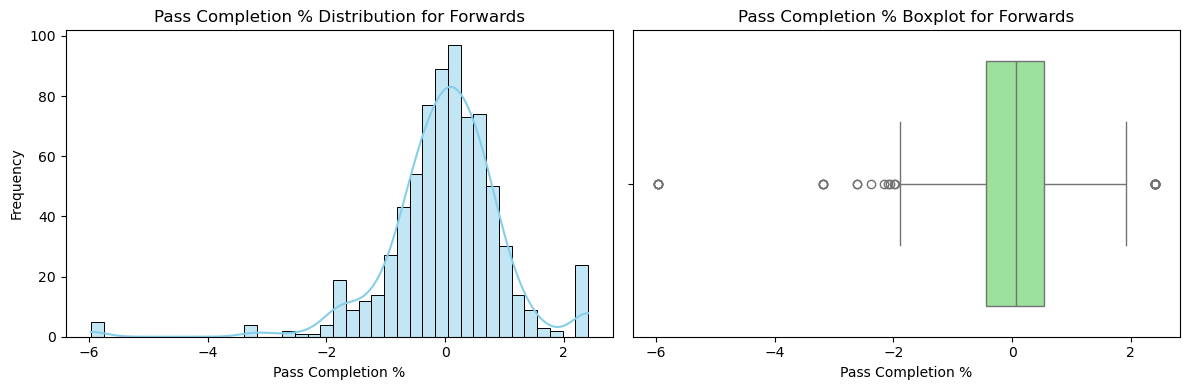

All plots have been saved as PNG files.


<Figure size 640x480 with 0 Axes>

In [36]:
def plot_and_save_plots(df, position, stats):
    for stat in stats:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        label = column_mapping.get(stat, stat)

        # histogram
        sns.histplot(df[label].dropna(), kde=True, ax=axes[0], color="skyblue")
        axes[0].set_title(f'{label} Distribution for {position}')
        axes[0].set_xlabel(label)
        axes[0].set_ylabel('Frequency')

        # boxplot
        sns.boxplot(x=df[label].dropna(), ax=axes[1], color="lightgreen")
        axes[1].set_title(f'{label} Boxplot for {position}')
        axes[1].set_xlabel(label)

        plt.tight_layout()
        plt.show()

        # saving plots
        filename = f"plots/{position}_{stat}_EDA.png".replace(" ", "_")
        plt.savefig(filename, format='png', dpi=300)
        plt.close(fig)

# generating and saving plots for each position
for position, df in dataframes.items():
    print(f"Saving plots for {position}...")
    plot_and_save_plots(df, position, basic_stats[position])

print("All plots have been saved as PNG files.")


<a id="correlation-heatmaps"></a>

## <div class='section'>Section 7: Correlation Heatmaps</div>

[Return to contents](#contents)

Finally, we create correlation heatmaps to explore any positive or negative relationships between features that may be useful for further analysis or model building.


In [37]:
def save_correlation_heatmap(df, position, stats):
    df_filtered = df[stats]
    corr = df_filtered.corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True,
                linewidths=0.5, annot_kws={"size": 8})
    plt.title(f'Correlation Heatmap for {position}', fontweight='bold', fontsize=14)
    plt.tight_layout()
    filename = f"heatmap/{position}_correlation_heatmap.png".replace(" ", "_")
    plt.savefig(filename, format='png', dpi=300)
    plt.close()

# generating and saving correlation heatmaps for each position
for position, df in dataframes.items():
    print(f"Generating correlation heatmap for {position}...")
    # save_correlation_heatmap(df, position, basic_stats[position])

print("All correlation heatmaps have been saved as PNG files.")


Generating correlation heatmap for Goalkeepers...
Generating correlation heatmap for Defenders...
Generating correlation heatmap for Midfielders...
Generating correlation heatmap for Forwards...
All correlation heatmaps have been saved as PNG files.


<a id="baseline-models"></a>

## <div class='section'>Section 8: PCA</div>

[Return to contents](#contents)

Here we are creating the baseline PCA models for each position.


<a id="baseline-models-defense"></a>

#### <div class='sub-section'>8.1: Defense PCA</div>


The total number of components is: 44.
The number of components required to explain 95% of the variance is: 15.


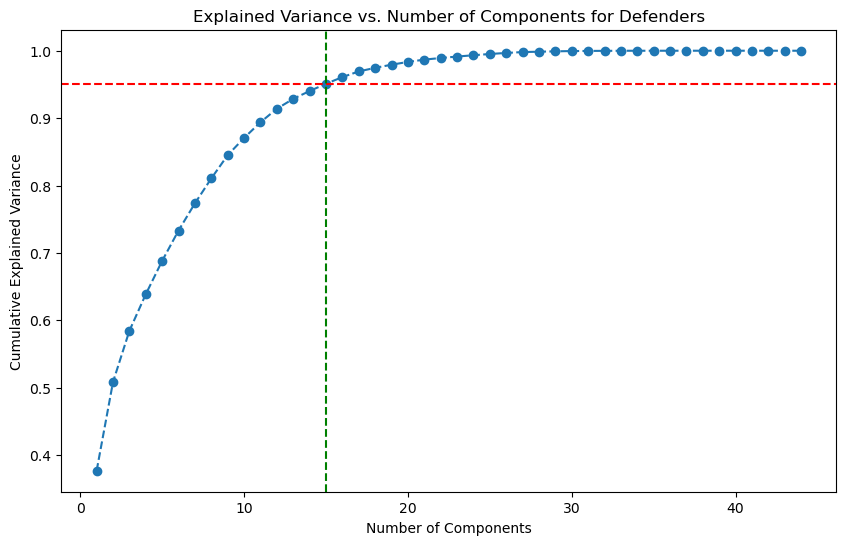

In [38]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

defender_train, defender_test = train_test_split(defenders, test_size=0.2, random_state=42)

numeric_train = defender_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').dropna()
numeric_test = defender_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').dropna()


defender_train = defender_train.loc[numeric_train.index].reset_index(drop=True)
defender_test = defender_test.loc[numeric_test.index].reset_index(drop=True)


y_train = defender_train['Comp']
y_test = defender_test['Comp']

pca = PCA()
pca1 = PCA()
defender_pca= pca.fit_transform(numeric_train)
defender_pca1= pca1.fit_transform(numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=valid_components, color='g', linestyle='--', label=f'{valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Defenders')
plt.show()

In order to explain 95% of the variancee, only 12 principal components are needed. The steepness of the initial curve demonstrates that only a small number of components determine most of the variance in defencer performance. This analysis is helpful for PCA because it gives insight into how many components will be most helpful for the final model. 

In [39]:
# defender_train = defender_train.reset_index(drop=True)
defender_train['PC1'] = defender_pca[:, 0]
defender_train['PC2'] = defender_pca[:, 1]

defender_test['PC1'] = defender_pca1[:, 0]
defender_test['PC2'] = defender_pca1[:, 1]

top_defenders = defender_train.nlargest(10, 'PC1')

print("Top 10 defenders based on PC1:")
print(top_defenders[['Player', 'PC1']])

Top 10 defenders based on PC1:
                     Player     PC1
355           Álex Grimaldo  16.477
289             Pedro Porro  13.702
221     Giovanni Di Lorenzo  11.757
757        Jeremie Frimpong  11.102
260        Antonee Robinson  10.345
413              David Raum  10.148
112         Kieran Trippier   9.912
454  Trent Alexander-Arnold   9.876
335           Alfie Doughty   9.801
55           Theo Hernández   9.550


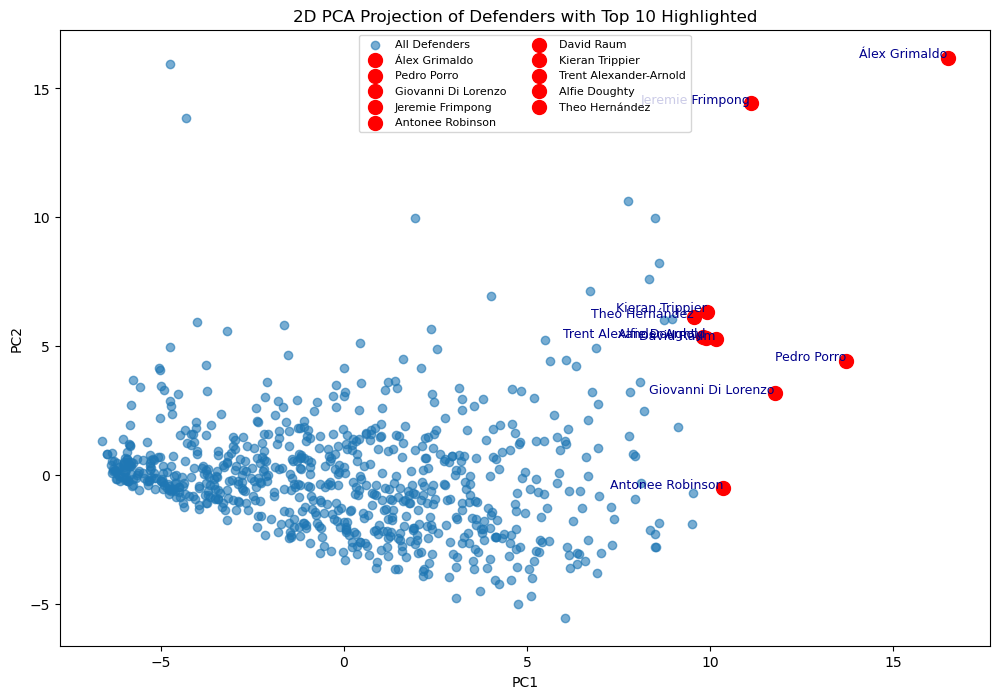

In [40]:

plt.figure(figsize=(12, 8))
plt.scatter(defender_pca[:, 0], defender_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_defenders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

This plot demonstrates that most of the defenders are clustered aroudn the origin. It is also apparent that there are no distinct groups outside of the large mass. However, the top defenders stand out significantly and are far away from the general cluster. 

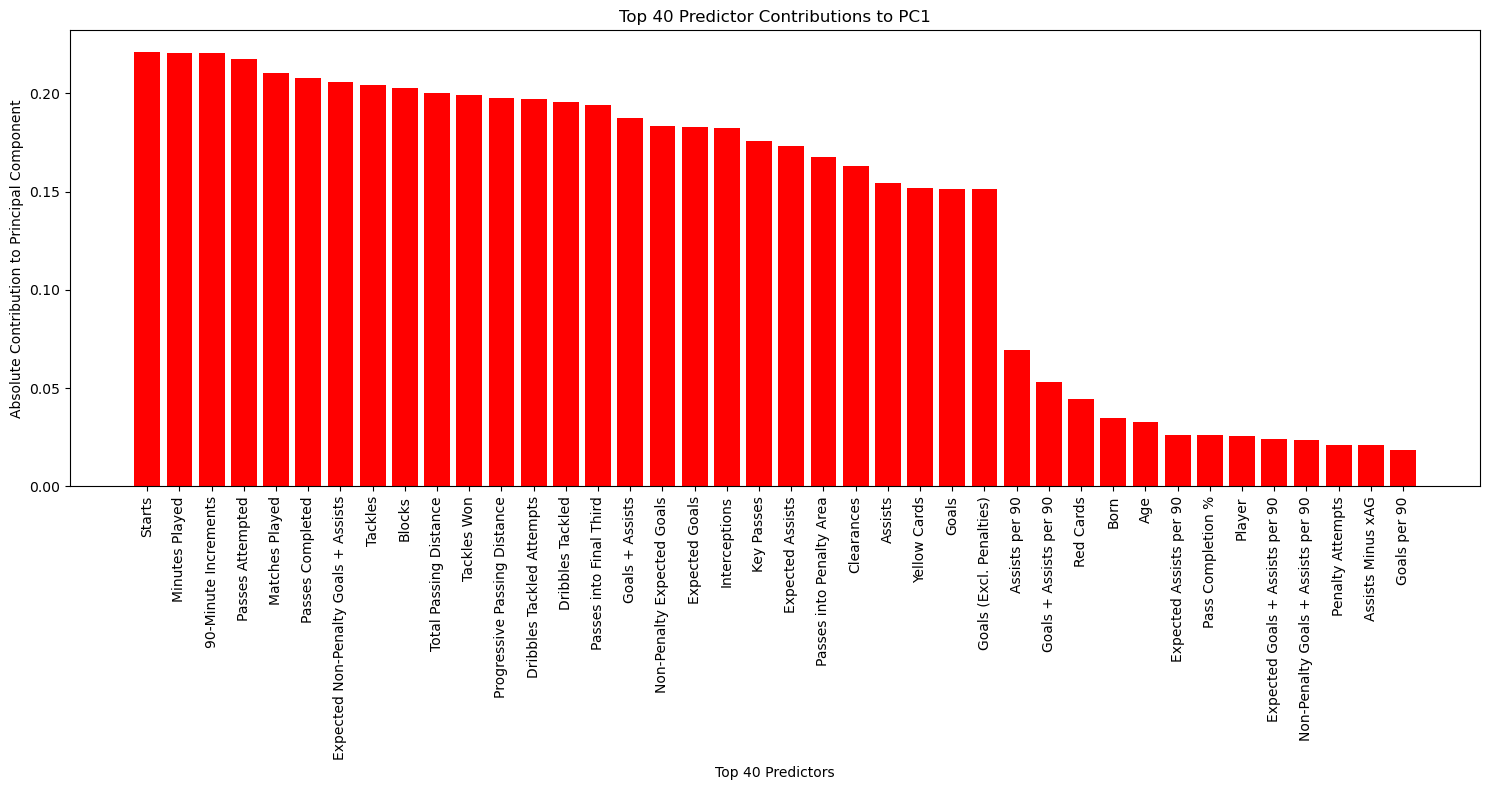

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = defender_train.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=90)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

In [42]:
x_train = defender_train.drop(columns=['Comp', 'Player'], errors='ignore')
x_test = defender_test.drop(columns=['Comp', 'Player'], errors='ignore')

# Initialize results DataFrame
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']
first_depth = 2
final_depth = 30
step = 1

# Perform decision tree tuning
results = []
for cur_criterion in criterion:      
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion, max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=x_train, y=y_train, cv=5, n_jobs=-1)

        cur_results = {'criterion': cur_criterion,
                       'depth': max_depth,
                       'all_cv': scores,
                       'mean_cv': scores.mean()}
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

# Best models for Gini and Entropy
best_gini = np.argmax(df_gini['mean_cv'])
best_entropy = np.argmax(df_entropy['mean_cv'])

best_depth_gini = df_gini['depth'].iloc[best_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_entropy]

model_tree_gini = DecisionTreeClassifier(max_depth=int(best_depth_gini), criterion='gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=int(best_depth_entropy), criterion='entropy')

model_tree_gini.fit(x_train, y_train)
model_tree_entropy.fit(x_train, y_train)

# Evaluate models
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(x_train))
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(x_train))

cv_acc_gini = df_gini['mean_cv'].iloc[best_gini]
cv_acc_entropy = df_entropy['mean_cv'].iloc[best_entropy]

print("================ [Gini Impurity] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_gini))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_gini))

print("\n================ [Entropy] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_entropy))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_entropy))

# Select the best model
if cv_acc_gini >= cv_acc_entropy:
    model = model_tree_gini
else:
    model = model_tree_entropy


pred = model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print("\nTest Accuracy: {:.2%}".format(test_acc))

# Save predictions
pred_df = pd.DataFrame({'Player': defender_test.loc[x_test.index, 'Player'], 'League': pred})
pred_df.to_csv('defensive_predictions.csv', index=False)


================ [Gini Impurity] ================
Training Accuracy: 97.76%
Cross-Validation Accuracy: 25.03%

================ [Entropy] ================
Training Accuracy: 75.63%
Cross-Validation Accuracy: 26.88%

Test Accuracy: 25.26%


#### <div class='sub-section'>Defense Bagging</div>

In [43]:
# Bagger function as provided in HW6
def bagger(
    n_trees: int,
    model: DecisionTreeClassifier,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    
    # set random seed for replicable results
    np.random.seed(random_seed)
    
    # instantiate arrays and list for storing results
    bagging_train = np.zeros((X_train.shape[0], n_trees)).astype(int)
    bagging_test = np.zeros((X_test.shape[0], n_trees)).astype(int)

    bagging_models_list = []

    # perform n bootstraps
    for i in range(n_trees):
        # generate bootstrapped model
        bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
        fitted_model = model.fit(bootstrapped_X, bootstrapped_y)
        bagging_models_list.append(fitted_model)

        # predict on full training and test sets and store
        # results to arrays
        bagging_train[:,i] = fitted_model.predict(X_train)
        bagging_test[:,i] = fitted_model.predict(X_test)
    
    # convert arrays to pandas dataframes as required
    bagging_train_df = pd.DataFrame(
        bagging_train[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    bagging_test_df = pd.DataFrame(
        bagging_test[:, :],
        columns=[f"model{x}" for x in range(n_trees)],
    )
    
    return bagging_train_df, bagging_test_df, bagging_models_list

In [44]:
#Use bagger on defenders
n_trees = 50

def_bag_train, def_bag_test, def_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
def_bag_train.head()

model0  model1  model2  model3  model4  model5  model6  model7  model8  \
0       0       0       0       0       0       4       0       0       0   
1       1       1       1       0       2       1       3       1       1   
2       2       4       4       4       4       2       4       4       4   
3       2       2       4       2       2       2       4       2       2   
4       2       1       2       2       2       1       1       1       1   

   model9  model10  model11  model12  model13  model14  model15  model16  \
0       0        4        0        0        3        0        0        2   
1       1        3        1        1        1        4        3        3   
2       4        4        0        4        4        2        4        2   
3       2        2        2        4        4        2        2        2   
4       2        2        1        3        2        0        3        2   

   model17  model18  model19  model20  model21  model22  model23  model24  \
0        4        0        0        0        0        0        3        3   
1        1        1        3        1        1        1        1        1   
2        4        3        4        4        4        4        1        4   
3        2        2        2        2        2        3        2        0   
4        0        2        1        1        1        2        2        2   

   model25  model26  model27  model28  model29  model30  model31  model32  \
0        0        1        0        0        0        0        0        0   
1        1        1        1        1        2        3        1        1   
2        4        3        4        2        4        4        4        3   
3        4        2        0        4        2        2        2        4   
4        1        3        3        0        0        1        3        0   

   model33  model34  model35  model36  model37  model38  model39  model40  \
0        4        4        0        0        0        0        0        0   
1        1        3        1        1        1        1        1        1   
2        4        4        4        4        4        4        3        0   
3        0        2        2        2        4        4        2        2   
4        1        2        4        1        2        1        1        1   

   model41  model42  model43  model44  model45  model46  model47  model48  \
0        3        2        0        0        0        2        0        0   
1        1        3        4        3        3        1        1        1   
2        4        2        4        4        4        4        2        2   
3        2        2        4        2        2        4        4        2   
4        3        1        2        2        2        2        1        4   

   model49  
0        0  
1        1  
2        4  
3        0  
4        3

In [45]:
# Get defender predictions
def_train_preds = def_bag_train.mode(axis=1)[0]
def_test_preds = def_bag_test.mode(axis=1)[0]

bagging_accuracy_def_train = sum(1 for x, y in zip(def_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_def_test = sum(1 for x, y in zip(def_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for defender statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_def_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_def_test:.4f}\n"
)

Bagging 50 trees for defender statistics gives the following accuracy scores:

	TRAIN	0.9855
	TEST	0.2474




<a id="baseline-models-midfielder"></a>

#### <div class='sub-section'>8.2: Midfielder PCA


The total number of components is: 72.
The number of components required to explain 95% of the variance is: 20.


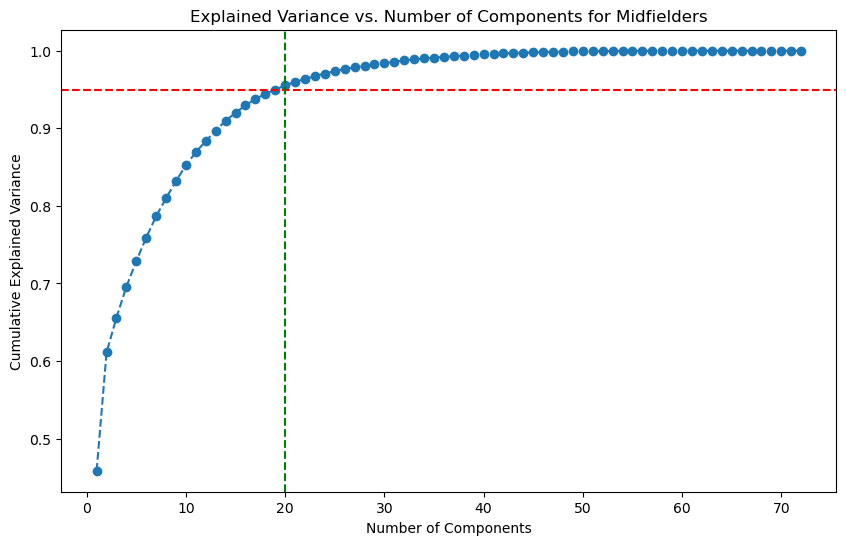

In [46]:
# #mapping
# midfielders.rename(columns=column_mapping, inplace=True)

# #Dropping NA from both datasets
# midfielders = midfielders.dropna().copy()
# numeric = midfielders.select_dtypes(include=[np.number])

# #Fitting the PCA
# pca = PCA().fit(numeric)
# pca_mid = pca.transform(numeric)

# #Calculating number of components and CI 
# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1 


# #Attaching PCA values to dataset
# midfielders['PC1'] = pca_mid[:, 0]
# midfielders['PC2'] = pca_mid[:, 1]

# #Printing findings
# print(f"The number of components is: {pca.n_components_}. ")
# print(f"The number of components required to explain 95% of the variance is: {n_components_95}")

# #confidence interval
# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
# plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
# plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components for Midfielders')
# plt.legend(loc='lower right')
# plt.show()


midfielders_train, midfielders_test = train_test_split(midfielders, test_size=0.2, random_state=42)

numeric_train = midfielders_train.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').dropna()
numeric_test = midfielders_test.select_dtypes(include='number').drop(columns=['Player'], errors='ignore').dropna()


midfielders_train = midfielders_train.loc[numeric_train.index].reset_index(drop=True)
midfielders_test = midfielders_test.loc[numeric_test.index].reset_index(drop=True)


y_train = midfielders_train['Comp']
y_test = midfielders_test['Comp']

pca = PCA()
pca1 = PCA()
midfielders_pca= pca.fit_transform(numeric_train)
midfielders_pca1= pca1.fit_transform(numeric_test)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The total number of components is: {pca.n_components_}.")
print(f"The number of components required to explain 95% of the variance is: {valid_components}.")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.axvline(x=valid_components, color='g', linestyle='--', label=f'{valid_components} Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Midfielders')
plt.show()

In [47]:
midfielders_train['PC1'] = midfielders_pca[:, 0]
midfielders_train['PC2'] = midfielders_pca[:, 1]

midfielders_test['PC1'] = midfielders_pca1[:, 0]
midfielders_test['PC2'] = midfielders_pca1[:, 1]

top_midfielders = midfielders_train.nlargest(10, 'PC1')

print("Top 10 midfielders based on PC1:")
print(top_midfielders[['Player', 'PC1']])

Top 10 midfielders based on PC1:
              Player     PC1
132            Rodri  19.005
106  Bruno Fernandes  17.779
555      Pascal Groß  17.695
242    Florian Wirtz  16.482
524  Martin Ødegaard  16.117
63   Bruno Guimarães  16.047
197      Xavi Simons  15.146
554      Declan Rice  14.049
439     Kevin Stöger  13.899
410    Téji Savanier  13.802


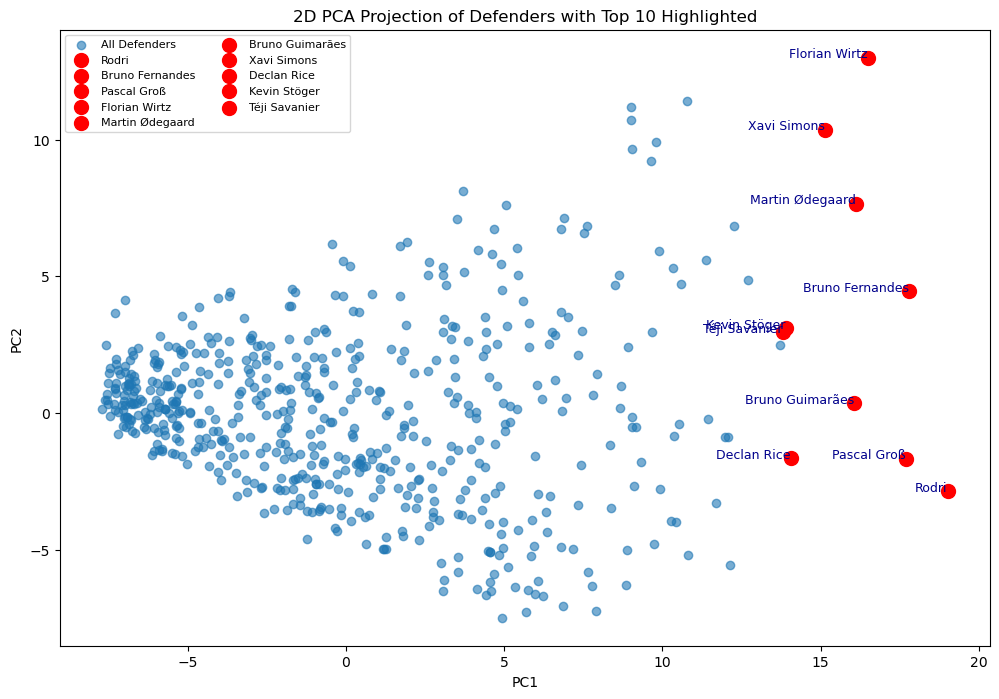

In [48]:
# graphing PCA with names
plt.figure(figsize=(12, 8))
plt.scatter(midfielders_pca[:, 0], midfielders_pca[:, 1], alpha=0.6, label="All Defenders")

for _, row in top_midfielders.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Defenders with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

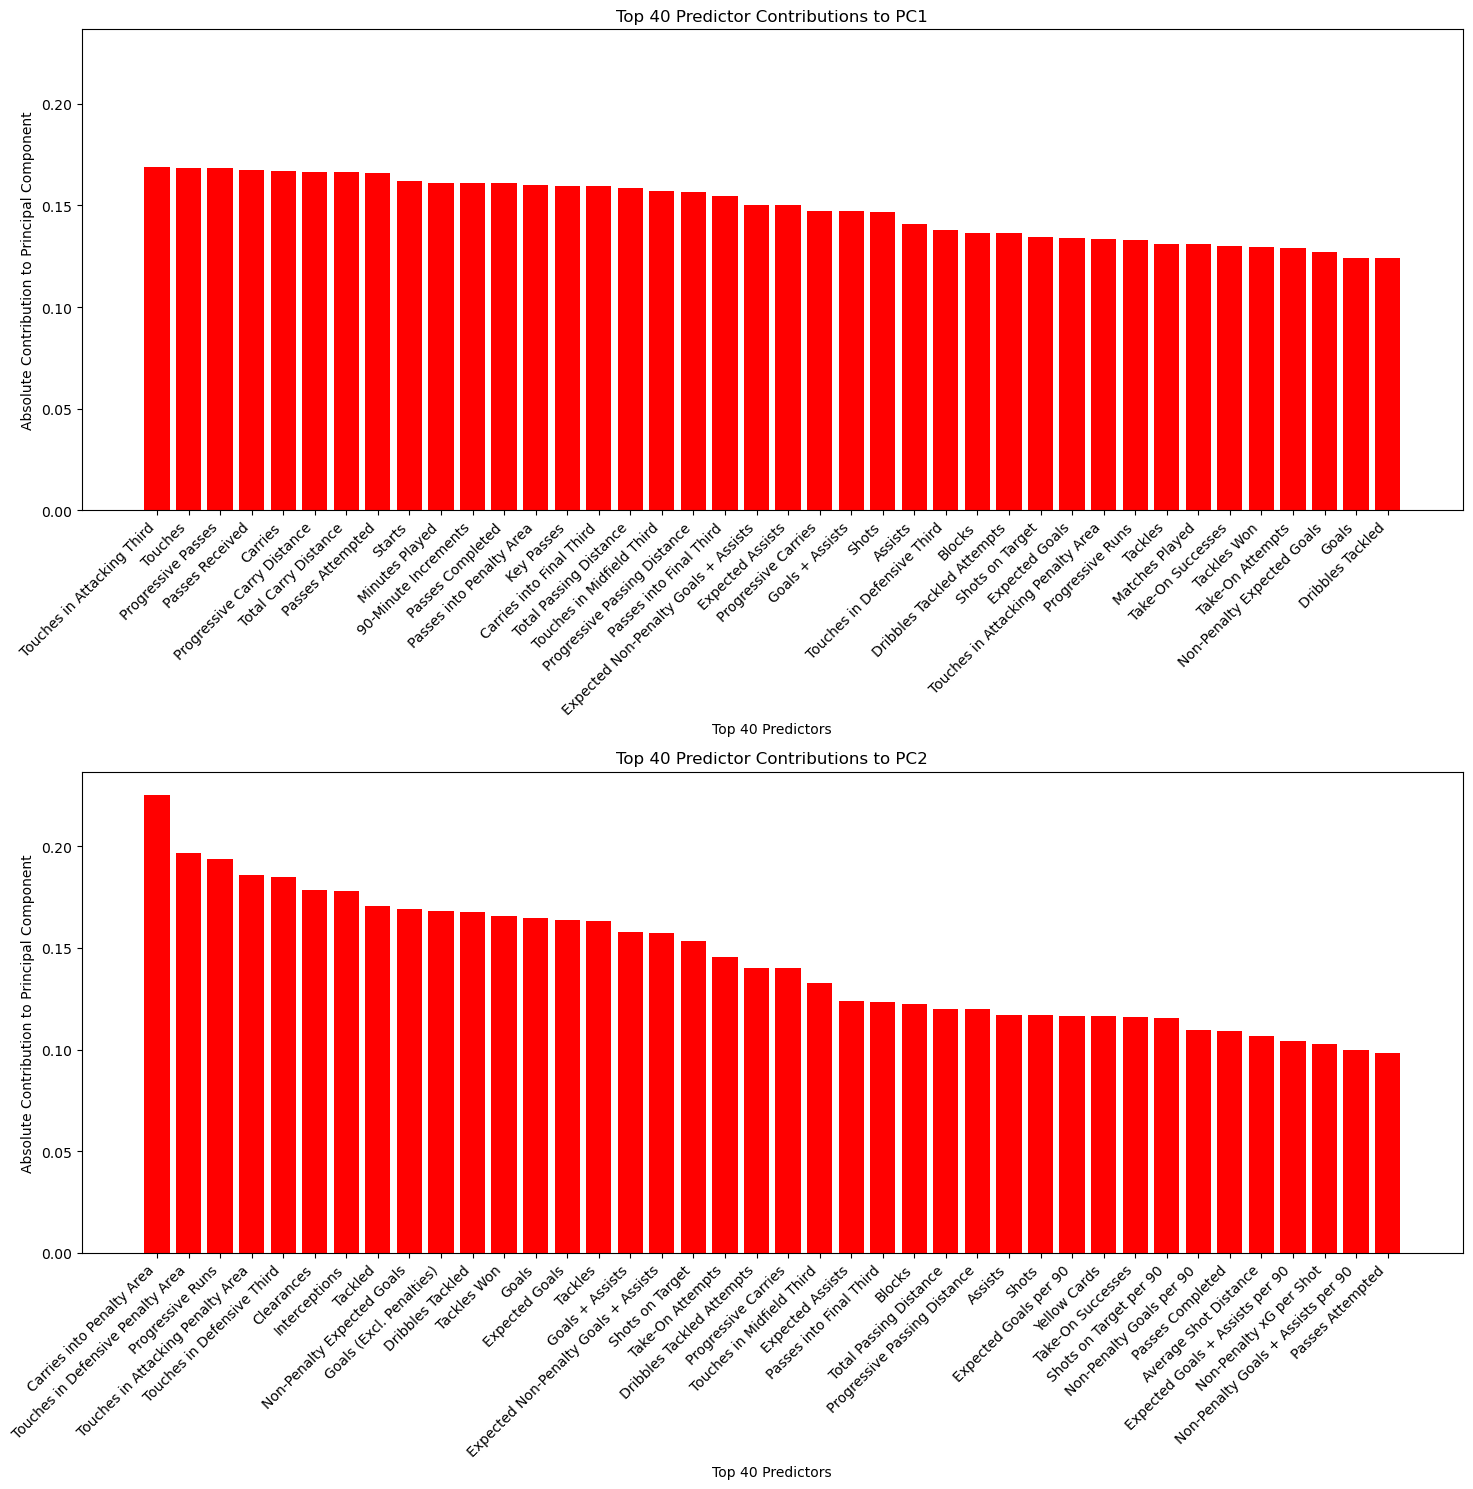

In [49]:
#Predictor Contributing to Components bar graph
num_components = 2

fig, axes = plt.subplots(num_components, 1, figsize=(15, 15), sharey=True)

for i in range(num_components):
    pc_loadings = pca.components_[i]
    absolute_loadings = np.abs(pc_loadings)  
   
    top_indices = np.argsort(absolute_loadings)[-40:][::-1]  
    top_features = midfielders.columns[top_indices]  
    top_contributions = absolute_loadings[top_indices]  

    axes[i].bar(top_features, top_contributions, color='red')
    axes[i].set_title(f'Top 40 Predictor Contributions to PC{i + 1}')
    axes[i].set_xticks(range(len(top_features)))
    axes[i].set_xticklabels(top_features, rotation=45, ha='right')
    axes[i].set_xlabel('Top 40 Predictors')
    axes[i].set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

In [50]:
x_train = midfielders_train.drop(columns=['Comp', 'Player'], errors='ignore')
x_test = midfielders_test.drop(columns=['Comp', 'Player'], errors='ignore')

# Initialize results DataFrame
df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']
first_depth = 2
final_depth = 30
step = 1

# Perform decision tree tuning
results = []
for cur_criterion in criterion:      
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion, max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=x_train, y=y_train, cv=5, n_jobs=-1)

        cur_results = {'criterion': cur_criterion,
                       'depth': max_depth,
                       'all_cv': scores,
                       'mean_cv': scores.mean()}
        results.append(cur_results)

df = pd.DataFrame(results)
best_param = df.sort_values(by='mean_cv', ascending=False).iloc[0]

df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

# Best models for Gini and Entropy
best_gini = np.argmax(df_gini['mean_cv'])
best_entropy = np.argmax(df_entropy['mean_cv'])

best_depth_gini = df_gini['depth'].iloc[best_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_entropy]

model_tree_gini = DecisionTreeClassifier(max_depth=int(best_depth_gini), criterion='gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=int(best_depth_entropy), criterion='entropy')

model_tree_gini.fit(x_train, y_train)
model_tree_entropy.fit(x_train, y_train)

# Evaluate models
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(x_train))
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(x_train))

cv_acc_gini = df_gini['mean_cv'].iloc[best_gini]
cv_acc_entropy = df_entropy['mean_cv'].iloc[best_entropy]

print("================ [Gini Impurity] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_gini))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_gini))

print("\n================ [Entropy] ================")
print("Training Accuracy: {:.2%}".format(acc_trees_train_entropy))
print("Cross-Validation Accuracy: {:.2%}".format(cv_acc_entropy))

# Select the best model
if cv_acc_gini >= cv_acc_entropy:
    model = model_tree_gini
else:
    model = model_tree_entropy


pred = model.predict(x_test)
test_acc = accuracy_score(y_test, pred)
print("\nTest Accuracy: {:.2%}".format(test_acc))

# Save predictions
pred_df = pd.DataFrame({'Player': defender_test.loc[x_test.index, 'Player'], 'League': pred})
pred_df.to_csv('defensive_predictions.csv', index=False)

================ [Gini Impurity] ================
Training Accuracy: 49.75%
Cross-Validation Accuracy: 27.85%

================ [Entropy] ================
Training Accuracy: 100.00%
Cross-Validation Accuracy: 31.76%

Test Accuracy: 27.45%


#### <div class='sub-section'>Midfield Bagging</div>

In [51]:
#Use bagger on midfielders
mid_bag_train, mid_bag_test, mid_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
mid_bag_train.head()

model0  model1  model2  model3  model4  model5  model6  model7  model8  \
0       4       4       4       4       4       4       4       4       4   
1       1       4       2       1       3       2       4       4       2   
2       2       1       1       1       1       4       1       1       1   
3       1       1       1       1       1       1       3       1       1   
4       3       0       3       3       3       3       2       3       0   

   model9  model10  model11  model12  model13  model14  model15  model16  \
0       4        4        4        4        4        4        4        4   
1       0        0        2        2        2        4        3        2   
2       1        1        1        1        1        2        1        0   
3       1        1        1        3        4        4        1        1   
4       3        3        3        2        3        3        1        3   

   model17  model18  model19  model20  model21  model22  model23  model24  \
0        2        4        4        4        4        4        4        4   
1        2        2        1        4        2        3        2        4   
2        1        1        3        0        2        1        2        1   
3        1        1        1        1        1        4        1        3   
4        0        3        0        2        3        3        3        0   

   model25  model26  model27  model28  model29  model30  model31  model32  \
0        4        4        4        4        4        4        4        4   
1        2        2        2        0        1        1        2        2   
2        1        1        1        1        1        0        1        4   
3        1        1        4        3        1        4        1        4   
4        1        3        3        1        3        1        3        2   

   model33  model34  model35  model36  model37  model38  model39  model40  \
0        2        4        4        4        4        4        4        4   
1        2        1        2        2        2        2        2        2   
2        3        1        1        4        1        1        2        3   
3        4        1        1        1        1        2        1        1   
4        3        3        1        4        3        0        0        3   

   model41  model42  model43  model44  model45  model46  model47  model48  \
0        4        4        4        4        4        4        4        4   
1        2        2        4        3        2        2        2        2   
2        1        2        1        1        1        1        2        2   
3        1        1        2        4        3        4        4        1   
4        3        3        3        3        3        0        3        0   

   model49  
0        0  
1        2  
2        1  
3        4  
4        3

In [52]:
# Get midfielder predictions
mid_train_preds = mid_bag_train.mode(axis=1)[0]
mid_test_preds = mid_bag_test.mode(axis=1)[0]

bagging_accuracy_mid_train = sum(1 for x, y in zip(mid_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_mid_test = sum(1 for x, y in zip(mid_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for midfielder statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_mid_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_mid_test:.4f}\n"
)

Bagging 50 trees for midfielder statistics gives the following accuracy scores:

	TRAIN	1.0000
	TEST	0.3268



<a id="baseline-models-goalkeeper"></a>

#### <div class='sub-section'>8.3: Goalkeeper PCA Baseline</div>

The number of components is: 20. 
The number of components required to explain 95% of the variance is: 7


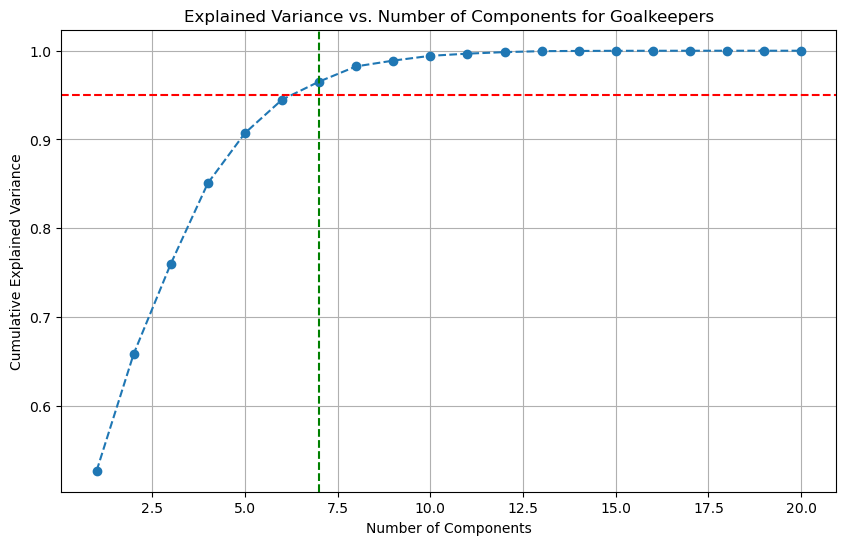

In [53]:
from sklearn.decomposition import PCA

#make sure to standardize the data below, if you read directly from the csv its not standardized 
#i think that will change the # of components that = 95%
#after uncomment the 95% line in your graph

goalkeepers_numeric = goalkeepers.select_dtypes(include=[np.number]).dropna()

pca = PCA()
pca_data = pca.fit_transform(goalkeepers_numeric)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
valid_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The number of components is: {pca.n_components_}. ")
print(f"The number of components required to explain 95% of the variance is: {valid_components}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axvline(x=valid_components, color='g', linestyle='--', label=f'{valid_components} Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Goalkeepers')
plt.grid()
plt.show()



In [54]:
pca_2d = PCA(n_components=2)
goalkeepers_pca = pca_2d.fit_transform(goalkeepers_numeric)
goalkeepers_df = goalkeepers.loc[goalkeepers_numeric.index] 
goalkeepers_df['PC1'] = goalkeepers_pca[:, 0]
goalkeepers_df['PC2'] = goalkeepers_pca[:, 1]

# the top 10 goalkeepers based on PC1
top_pc1_goalkeepers = goalkeepers_df[['Player', 'PC1']].sort_values(by='PC1', ascending=False).head(10)

print("\nTop 10 goalkeepers based on PC1:")
print(top_pc1_goalkeepers)



Top 10 goalkeepers based on PC1:
                   Player    PC1
18            André Onana  5.301
63        Filip Jørgensen  4.910
186       Thomas Kaminski  4.793
154       Paulo Gazzaniga  4.712
94        Jordan Pickford  4.665
95                José Sá  4.568
69   Giorgi Mamardashvili  4.533
124          Mark Flekken  4.509
32             Bernd Leno  4.436
72      Guglielmo Vicario  4.436


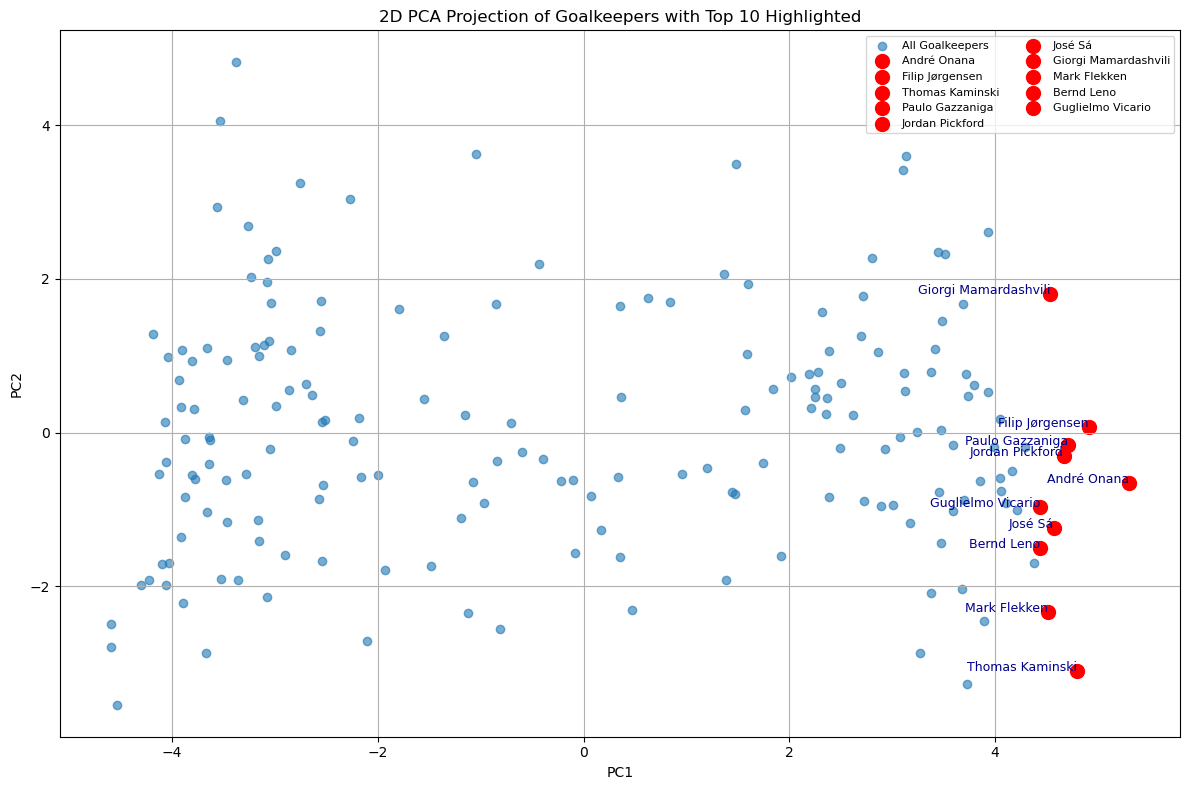

In [55]:
plt.figure(figsize=(12, 8))

plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.6, label="All Goalkeepers")

for _, row in top_pc1_goalkeepers.iterrows():
    pc1_value = row['PC1']
    pc2_value = goalkeepers_df.loc[goalkeepers_df['Player'] == row['Player'], 'PC2'].values[0]
    plt.scatter(pc1_value, pc2_value, color='red', s=100, label=row['Player'])
    plt.text(pc1_value, pc2_value, row['Player'], fontsize=9, ha='right', color='darkblue')
    

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeepers with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.grid()
plt.tight_layout()
plt.show()

In [56]:
#instead of listing them we are using the red bar graphs, similar to benistas code

features = goalkeepers_numeric.columns
pc_loadings = pca_2d.components_
pc1_pc2_loadings = pd.DataFrame(pc_loadings[:2], columns=features, index=['PC1', 'PC2']).T

print("\nTop features contributing to PC1:")
print(pc1_pc2_loadings['PC1'].sort_values(ascending=False).head(5))

print("\nTop features contributing to PC2:")
print(pc1_pc2_loadings['PC2'].sort_values(ascending=False).head(5))

'''
Example code:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = forward_nums.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=45)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()
'''



Top features contributing to PC1:
Matches Played          0.313
90-Minute Increments    0.312
Minutes Played          0.312
Starts                  0.311
Opponent Shots          0.310
Name: PC1, dtype: float64

Top features contributing to PC2:
Comp                                   0.436
Clean Sheet Percentage                 0.408
Born                                   0.401
Save Percentage                        0.292
Post-Shot Expected Goals Difference    0.281
Name: PC2, dtype: float64


"\nExample code:\nfig, ax = plt.subplots(1, 1, figsize=(15, 10))\npc_loadings = pca.components_[0]\nabsolute_loadings = np.abs(pc_loadings)\n\ntop_indices = np.argsort(absolute_loadings)[-40:][::-1]\ntop_features = forward_nums.columns[top_indices]\ntop_contributions = absolute_loadings[top_indices]\nax.bar(top_features, top_contributions, color='red')\nax.set_title('Top 40 Predictor Contributions to PC1')\nax.set_xticks(range(len(top_features)))\nax.set_xticklabels(top_features, rotation=45)\nax.set_xlabel('Top 40 Predictors')\nax.set_ylabel('Absolute Contribution to Principal Component')\n\nplt.tight_layout()\nplt.show()\n"

In [57]:
#i think we only need the pca graph where you call out names so you can edit this out

'''
pca_2d = PCA(n_components=2)
goalkeepers_pca = pca_2d.fit_transform(goalkeepers_numeric)
plt.figure(figsize=(12, 8))
plt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.7, edgecolors='k', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Goalkeeper Data")
plt.grid()
plt.tight_layout()
plt.show()
'''


'\npca_2d = PCA(n_components=2)\ngoalkeepers_pca = pca_2d.fit_transform(goalkeepers_numeric)\nplt.figure(figsize=(12, 8))\nplt.scatter(goalkeepers_pca[:, 0], goalkeepers_pca[:, 1], alpha=0.7, edgecolors=\'k\', s=50)\nplt.xlabel("PC1")\nplt.ylabel("PC2")\nplt.title("2D PCA Projection of Goalkeeper Data")\nplt.grid()\nplt.tight_layout()\nplt.show()\n'

<div class='sub-section'>Goalkeeper Bagging</div>

In [58]:
#Use bagger on goalkeepers
gk_bag_train, gk_bag_test, gk_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
gk_bag_train.head()

model0  model1  model2  model3  model4  model5  model6  model7  model8  \
0       4       4       4       4       4       4       4       4       4   
1       1       4       2       1       3       2       4       4       2   
2       2       1       1       1       1       4       1       1       1   
3       1       1       1       1       1       1       3       1       1   
4       3       0       3       3       3       3       2       3       0   

   model9  model10  model11  model12  model13  model14  model15  model16  \
0       4        4        4        4        4        4        4        4   
1       0        0        2        2        2        4        3        2   
2       1        1        1        1        1        2        1        0   
3       1        1        1        3        4        4        1        1   
4       3        3        3        2        3        3        1        3   

   model17  model18  model19  model20  model21  model22  model23  model24  \
0        2        4        4        4        4        4        4        4   
1        2        2        1        4        2        3        2        4   
2        1        1        3        0        2        1        2        1   
3        1        1        1        1        1        4        1        3   
4        0        3        0        2        3        3        3        0   

   model25  model26  model27  model28  model29  model30  model31  model32  \
0        4        4        4        4        4        4        4        4   
1        2        2        2        0        1        1        2        2   
2        1        1        1        1        1        0        1        4   
3        1        1        4        3        1        4        1        4   
4        1        3        3        1        3        1        3        2   

   model33  model34  model35  model36  model37  model38  model39  model40  \
0        2        4        4        4        4        4        4        4   
1        2        1        2        2        2        2        2        2   
2        3        1        1        4        1        1        2        3   
3        4        1        1        1        1        2        1        1   
4        3        3        1        4        3        0        0        3   

   model41  model42  model43  model44  model45  model46  model47  model48  \
0        4        4        4        4        4        4        4        4   
1        2        2        4        3        2        2        2        2   
2        1        2        1        1        1        1        2        2   
3        1        1        2        4        3        4        4        1   
4        3        3        3        3        3        0        3        0   

   model49  
0        0  
1        2  
2        1  
3        4  
4        3

In [59]:
# Get goalkeeper predictions
gk_train_preds = gk_bag_train.mode(axis=1)[0]
gk_test_preds = gk_bag_test.mode(axis=1)[0]

bagging_accuracy_gk_train = sum(1 for x, y in zip(gk_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_gk_test = sum(1 for x, y in zip(gk_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for goalkeeper statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_gk_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_gk_test:.4f}\n"
)

Bagging 50 trees for goalkeeper statistics gives the following accuracy scores:

	TRAIN	1.0000
	TEST	0.3268



<a id="baseline-models-forward"></a>

#### <div class='sub-section'>8.4: Forward PCA</div>

The number of components is: 63. 
The number of components required to explain 95% of the variance is: 18


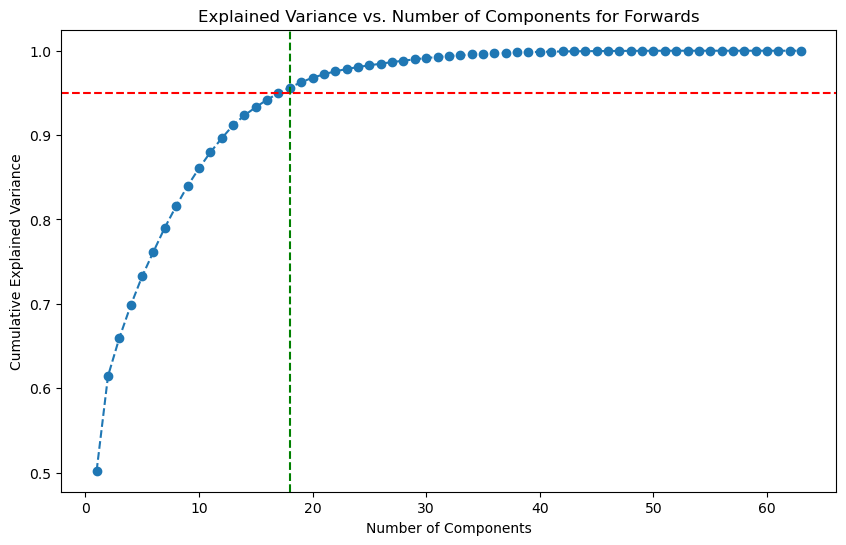

In [60]:
forward_nums = forwards.select_dtypes(include=[np.number]).dropna()

#make sure to standardize the data above, if you read directly from the csv its not standardized yet
#i think that will change the # of components that = 95%
#after uncomment the 95% line in your graph

pca = PCA()
pca_forwards = pca.fit_transform(forward_nums)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_components = np.argmax(cumulative_variance >= 0.95) + 1

print(f"The number of components is: {pca.n_components_}. ")
print(f"The number of components required to explain 95% of the variance is: {optimal_components}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance,marker='o', linestyle='--')
plt.axvline(x=optimal_components, color='g', linestyle='--', label=f'{optimal_components} Components')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components for Forwards')
plt.show()

In [61]:
forwards = forwards.loc[forward_nums.index]
forwards['PC1'] = pca_forwards[:, 0]
forwards['PC2'] = pca_forwards[:, 1]

top_forwards = forwards.nlargest(10, 'PC1')
print("Top 10 forwards based on PC1:")
print(top_forwards[['Player', 'PC1', 'PC2']])

Top 10 forwards based on PC1:
                    Player     PC1    PC2
157            Cole Palmer  18.696  2.015
129            Bukayo Saka  18.524 -0.324
592             Phil Foden  17.269 -1.438
491           Matìas Soulé  16.999 -6.192
404  Khvicha Kvaratskhelia  15.896 -3.671
411          Kylian Mbappé  15.235  5.715
528          Mohamed Salah  15.001  5.021
655                  Sávio  14.633 -5.557
633    Romain Del Castillo  14.335 -6.050
682          Son Heung-min  13.910  1.143


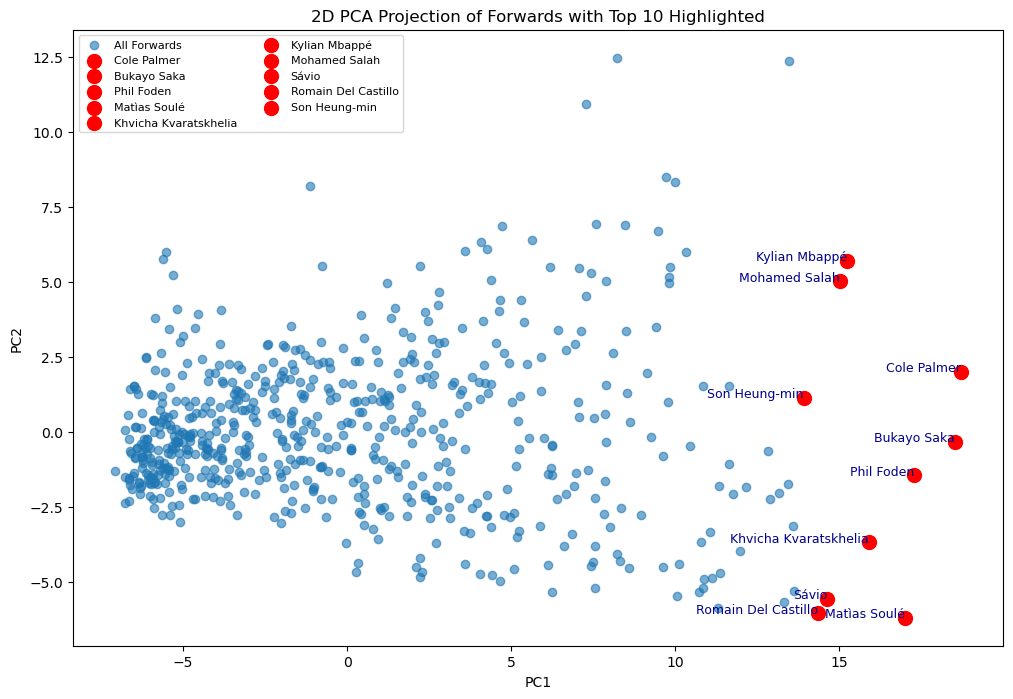

In [62]:
plt.figure(figsize=(12, 8))
plt.scatter(pca_forwards[:, 0], pca_forwards[:, 1], alpha=0.6, label="All Forwards")

for _, row in top_forwards.iterrows():
    pc1 = row['PC1']
    pc2 = row['PC2']
    plt.scatter(pc1, pc2, color='red', s=100, label=row['Player'])
    plt.text(pc1, pc2, row['Player'], fontsize=9, ha='right', color='darkblue')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("2D PCA Projection of Forwards with Top 10 Highlighted")
plt.legend(loc='best', fontsize=8, ncol=2)
plt.show()

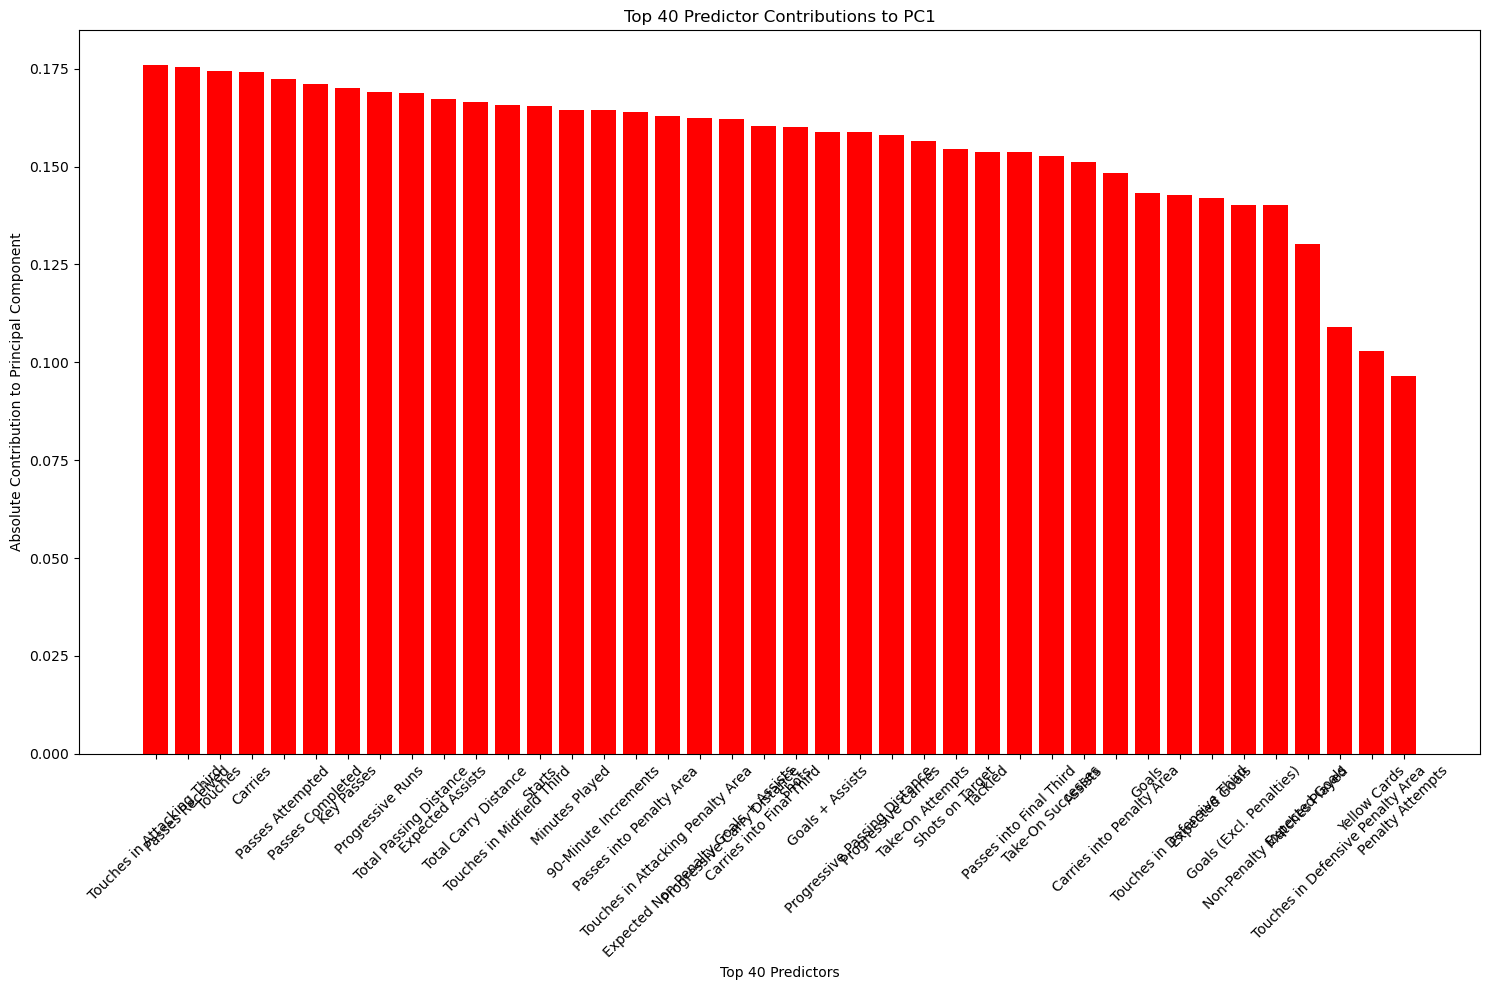

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
pc_loadings = pca.components_[0]
absolute_loadings = np.abs(pc_loadings)

top_indices = np.argsort(absolute_loadings)[-40:][::-1]
top_features = forward_nums.columns[top_indices]
top_contributions = absolute_loadings[top_indices]
ax.bar(top_features, top_contributions, color='red')
ax.set_title('Top 40 Predictor Contributions to PC1')
ax.set_xticks(range(len(top_features)))
ax.set_xticklabels(top_features, rotation=45)
ax.set_xlabel('Top 40 Predictors')
ax.set_ylabel('Absolute Contribution to Principal Component')

plt.tight_layout()
plt.show()

<div class='sub-section'>Forward Bagging</div>

In [64]:
#Use bagger on goalkeepers
fwd_bag_train, fwd_bag_test, fwd_bag_models = bagger(n_trees, model, x_train, y_train, x_test)
fwd_bag_train.head()

model0  model1  model2  model3  model4  model5  model6  model7  model8  \
0       4       4       4       4       4       4       4       4       4   
1       1       4       2       1       3       2       4       4       2   
2       2       1       1       1       1       4       1       1       1   
3       1       1       1       1       1       1       3       1       1   
4       3       0       3       3       3       3       2       3       0   

   model9  model10  model11  model12  model13  model14  model15  model16  \
0       4        4        4        4        4        4        4        4   
1       0        0        2        2        2        4        3        2   
2       1        1        1        1        1        2        1        0   
3       1        1        1        3        4        4        1        1   
4       3        3        3        2        3        3        1        3   

   model17  model18  model19  model20  model21  model22  model23  model24  \
0        2        4        4        4        4        4        4        4   
1        2        2        1        4        2        3        2        4   
2        1        1        3        0        2        1        2        1   
3        1        1        1        1        1        4        1        3   
4        0        3        0        2        3        3        3        0   

   model25  model26  model27  model28  model29  model30  model31  model32  \
0        4        4        4        4        4        4        4        4   
1        2        2        2        0        1        1        2        2   
2        1        1        1        1        1        0        1        4   
3        1        1        4        3        1        4        1        4   
4        1        3        3        1        3        1        3        2   

   model33  model34  model35  model36  model37  model38  model39  model40  \
0        2        4        4        4        4        4        4        4   
1        2        1        2        2        2        2        2        2   
2        3        1        1        4        1        1        2        3   
3        4        1        1        1        1        2        1        1   
4        3        3        1        4        3        0        0        3   

   model41  model42  model43  model44  model45  model46  model47  model48  \
0        4        4        4        4        4        4        4        4   
1        2        2        4        3        2        2        2        2   
2        1        2        1        1        1        1        2        2   
3        1        1        2        4        3        4        4        1   
4        3        3        3        3        3        0        3        0   

   model49  
0        0  
1        2  
2        1  
3        4  
4        3

In [65]:
# Get goalkeeper predictions
fwd_train_preds = fwd_bag_train.mode(axis=1)[0]
fwd_test_preds = fwd_bag_test.mode(axis=1)[0]

bagging_accuracy_fwd_train = sum(1 for x, y in zip(fwd_train_preds, y_train) if x == y)/len(y_train)
bagging_accuracy_fwd_test = sum(1 for x, y in zip(fwd_test_preds, y_test) if x == y)/len(y_test)

print(
    f"Bagging {n_trees} trees for forward statistics gives "
    f"the following accuracy scores:\n\n\tTRAIN\t"
    f"{bagging_accuracy_fwd_train:.4f}\n\tTEST\t"
    f"{bagging_accuracy_fwd_test:.4f}\n"
)

Bagging 50 trees for forward statistics gives the following accuracy scores:

	TRAIN	1.0000
	TEST	0.3268

